# Malware detection

<h1> Exploratory Data Analysis</h1>

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#separating byte files and asm files 

source = 'train'
destination = 'byteFiles'

# we will check if the folder 'byteFiles' exists if it not there we will create a folder with the same name
if not os.path.isdir(destination):
    os.makedirs(destination)
if os.path.isdir(source):
    os.rename(source,'asmFiles')
    source='asmFiles'
    data_files = os.listdir(source)
    for file in asm_files:
        if (file.endswith("bytes")):
            shutil.move(source+file,destination)

<h2> Distribution of malware classes in whole data set </h2>

<IPython.core.display.Javascript object>


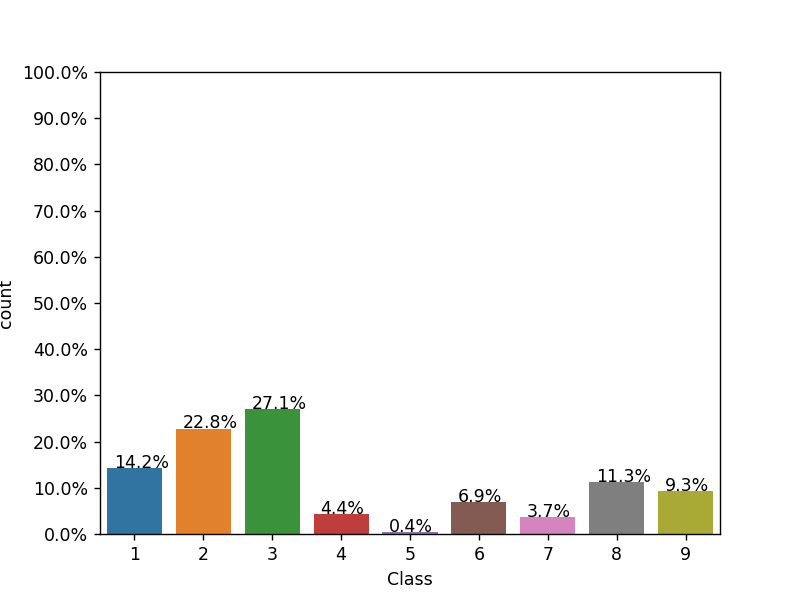

In [ ]:
Y=pd.read_csv("trainLabels.csv")
total = len(Y)*1.
ax=sns.countplot(x="Class", data=Y)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

<h2>Feature extraction </h2>

<h3> File size  of byte files as a feature </h3>

In [ ]:
#file sizes of byte files

files=os.listdir('byteFiles')
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    statinfo=os.stat('byteFiles/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
data_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
print (data_size_byte.head())

   Class                    ID      size
0      9  01azqd4InC7m9JpocGv5  4.234863
1      2  01IsoiSMh5gxyDYTl4CB  5.538818
2      9  01jsnpXSAlgw6aPeDxrU  3.887939
3      1  01kcPWA9K2BOxQeS5Rju  0.574219
4      8  01SuzwMJEIXsK7A8dQbl  0.370850


<h3> box plots of file size (.byte files) feature </h3>

<IPython.core.display.Javascript object>


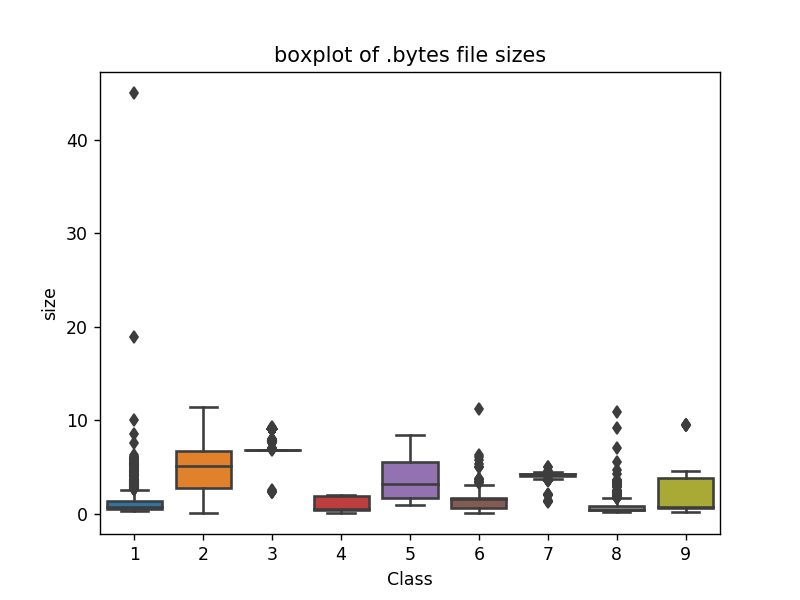

In [ ]:
#boxplot of byte files
ax = sns.boxplot(x="Class", y="size", data=data_size_byte)
plt.title("boxplot of .bytes file sizes")
plt.show()

<h3>feature extraction from byte files </h3>

In [ ]:

files = os.listdir('byteFiles')
filenames=[]
array=[]
for file in files:
    if(f.endswith("bytes")):
        file=file.split('.')[0]
        text_file = open('byteFiles/'+file+".txt", 'w+')
        with open('byteFiles/'+file,"r") as fp:
            lines=""
            for line in fp:
                a=line.rstrip().split(" ")[1:]
                b=' '.join(a)
                b=b+"\n"
                text_file.write(b)
            fp.close()
            os.remove('byteFiles/'+file)
        text_file.close()

files = os.listdir('byteFiles')
filenames2=[]
feature_matrix = np.zeros((len(files),257),dtype=int)
k=0


#program to convert into bag of words of bytefiles
#this is custom-built bag of words this is unigram bag of words
byte_feature_file=open('result.csv','w+')
byte_feature_file.write("ID,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??")
for file in files:
    filenames2.append(f)
    byte_feature_file.write(file+",")
    if(file.endswith("txt")):
        with open('byteFiles/'+file,"r") as byte_flie:
            for lines in byte_flie:
                line=lines.rstrip().split(" ")
                for hex_code in line:
                    if hex_code=='??':
                        feature_matrix[k][256]+=1
                    else:
                        feature_matrix[k][int(hex_code,16)]+=1
        byte_flie.close()
    for i in feature_matrix[k]:
        byte_feature_file.write(str(i)+",")
    byte_feature_file.write("\n")
    
    k += 1

byte_feature_file.close()

In [ ]:
byte_features=pd.read_csv("result.csv")
print (byte_features.head())

                     ID       0     1     2     3     4     5     6     7  \
0  01azqd4InC7m9JpocGv5  601905  3905  2816  3832  3345  3242  3650  3201   
1  01IsoiSMh5gxyDYTl4CB   39755  8337  7249  7186  8663  6844  8420  7589   
2  01jsnpXSAlgw6aPeDxrU   93506  9542  2568  2438  8925  9330  9007  2342   
3  01kcPWA9K2BOxQeS5Rju   21091  1213   726   817  1257   625   550   523   
4  01SuzwMJEIXsK7A8dQbl   19764   710   302   433   559   410   262   249   

      8  ...      f7    f8    f9    fa    fb    fc    fd     fe     ff     ??  
0  2965  ...    2804  3687  3101  3211  3097  2758  3099   2759   5753   1824  
1  9291  ...     451  6536   439   281   302  7639   518  17001  54902   8588  
2  9107  ...    2325  2358  2242  2885  2863  2471  2786   2680  49144    468  
3  1078  ...     478   873   485   462   516  1133   471    761   7998  13940  
4   422  ...     847   947   350   209   239   653   221    242   2199   9008  

[5 rows x 258 columns]


In [ ]:
result = pd.merge(byte_features, data_size_byte,on='ID', how='left')
result.head()

ID       0     1     2     3     4     5     6     7  \
0  01azqd4InC7m9JpocGv5  601905  3905  2816  3832  3345  3242  3650  3201   
1  01IsoiSMh5gxyDYTl4CB   39755  8337  7249  7186  8663  6844  8420  7589   
2  01jsnpXSAlgw6aPeDxrU   93506  9542  2568  2438  8925  9330  9007  2342   
3  01kcPWA9K2BOxQeS5Rju   21091  1213   726   817  1257   625   550   523   
4  01SuzwMJEIXsK7A8dQbl   19764   710   302   433   559   410   262   249   

      8    ...       f9    fa    fb    fc    fd     fe     ff     ??  Class  \
0  2965    ...     3101  3211  3097  2758  3099   2759   5753   1824      9   
1  9291    ...      439   281   302  7639   518  17001  54902   8588      2   
2  9107    ...     2242  2885  2863  2471  2786   2680  49144    468      9   
3  1078    ...      485   462   516  1133   471    761   7998  13940      1   
4   422    ...      350   209   239   653   221    242   2199   9008      8   

       size  
0  4.234863  
1  5.538818  
2  3.887939  
3  0.574219  
4  0.370850  

[5 rows x 260 columns]

In [ ]:
# https://stackoverflow.com/a/29651514
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1
result = normalize(result)

In [ ]:
data_y = result['Class']
result.head()

ID         0         1         2         3         4  \
0  01azqd4InC7m9JpocGv5  0.262806  0.005498  0.001567  0.002067  0.002048   
1  01IsoiSMh5gxyDYTl4CB  0.017358  0.011737  0.004033  0.003876  0.005303   
2  01jsnpXSAlgw6aPeDxrU  0.040827  0.013434  0.001429  0.001315  0.005464   
3  01kcPWA9K2BOxQeS5Rju  0.009209  0.001708  0.000404  0.000441  0.000770   
4  01SuzwMJEIXsK7A8dQbl  0.008629  0.001000  0.000168  0.000234  0.000342   

          5         6         7         8    ...           f9        fa  \
0  0.001835  0.002058  0.002946  0.002638    ...     0.013560  0.013107   
1  0.003873  0.004747  0.006984  0.008267    ...     0.001920  0.001147   
2  0.005280  0.005078  0.002155  0.008104    ...     0.009804  0.011777   
3  0.000354  0.000310  0.000481  0.000959    ...     0.002121  0.001886   
4  0.000232  0.000148  0.000229  0.000376    ...     0.001530  0.000853   

         fb        fc        fd        fe        ff        ??  Class      size  
0  0.013634  0.031724  0.014549  0.014348  0.007843  0.000129      9  0.092219  
1  0.001329  0.087867  0.002432  0.088411  0.074851  0.000606      2  0.121236  
2  0.012604  0.028423  0.013080  0.013937  0.067001  0.000033      9  0.084499  
3  0.002272  0.013032  0.002211  0.003957  0.010904  0.000984      1  0.010759  
4  0.001052  0.007511  0.001038  0.001258  0.002998  0.000636      8  0.006233  

[5 rows x 260 columns]

<h3> Multivariate Analysis </h3>

<IPython.core.display.Javascript object>


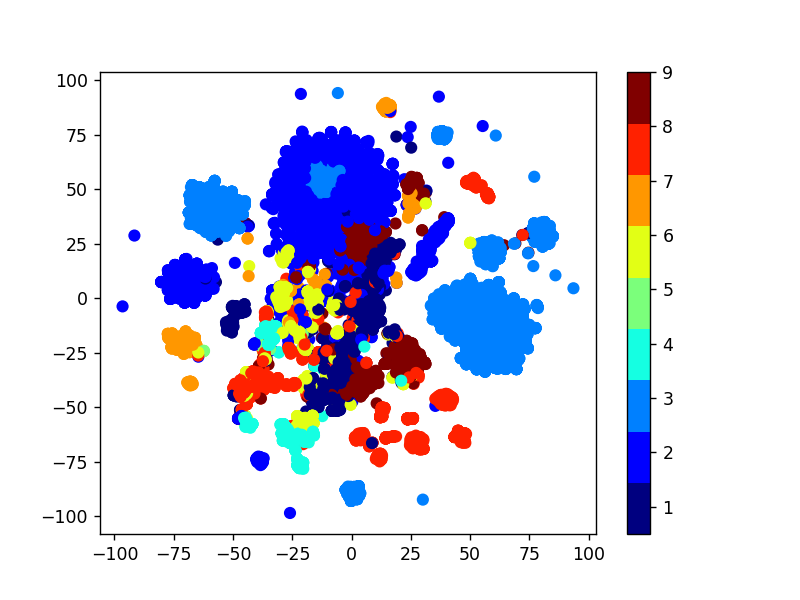

In [ ]:
#multivariate analysis on byte files
#this is with perplexity 50
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(result.drop(['ID','Class'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

<IPython.core.display.Javascript object>


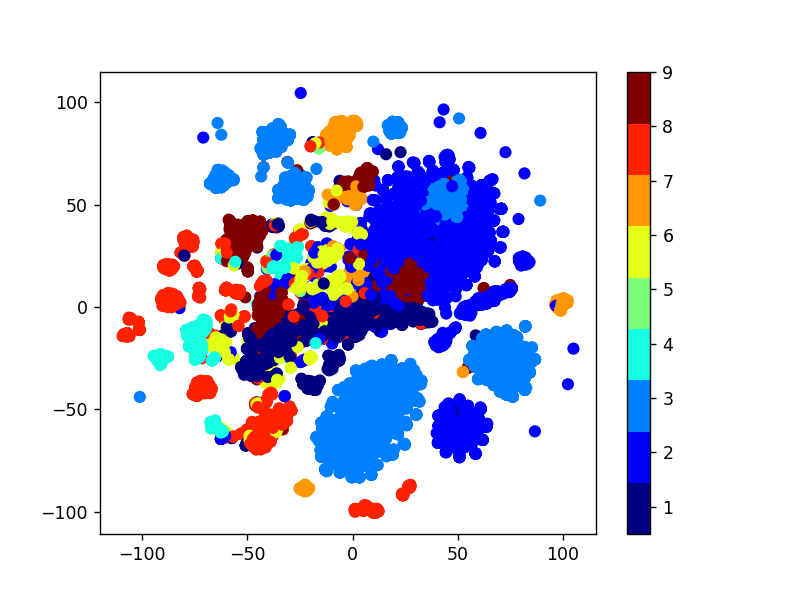

In [ ]:
#this is with perplexity 30
xtsne=TSNE(perplexity=30)
results=xtsne.fit_transform(result.drop(['ID','Class'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

# Train Test split

In [ ]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 6955
Number of data points in test data: 2174
Number of data points in cross validation data: 1739


<IPython.core.display.Javascript object>


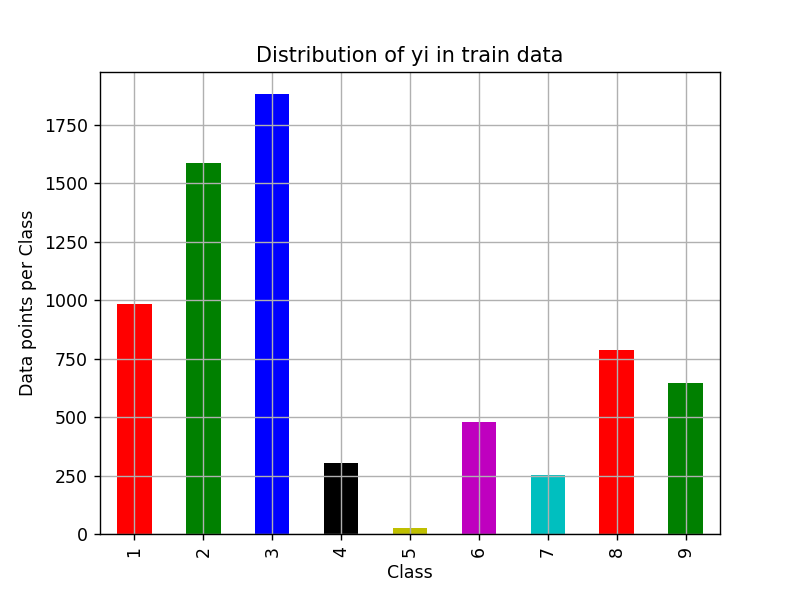

Number of data points in class 3 : 1883 ( 27.074 %)
Number of data points in class 2 : 1586 ( 22.804 %)
Number of data points in class 1 : 986 ( 14.177 %)
Number of data points in class 8 : 786 ( 11.301 %)
Number of data points in class 9 : 648 ( 9.317 %)
Number of data points in class 6 : 481 ( 6.916 %)
Number of data points in class 4 : 304 ( 4.371 %)
Number of data points in class 7 : 254 ( 3.652 %)
Number of data points in class 5 : 27 ( 0.388 %)
--------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


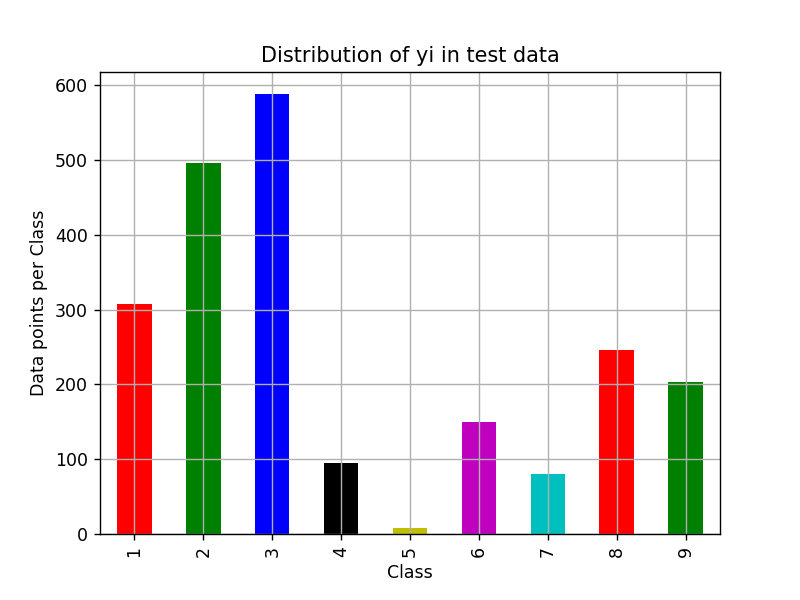

Number of data points in class 3 : 588 ( 27.047 %)
Number of data points in class 2 : 496 ( 22.815 %)
Number of data points in class 1 : 308 ( 14.167 %)
Number of data points in class 8 : 246 ( 11.316 %)
Number of data points in class 9 : 203 ( 9.338 %)
Number of data points in class 6 : 150 ( 6.9 %)
Number of data points in class 4 : 95 ( 4.37 %)
Number of data points in class 7 : 80 ( 3.68 %)
Number of data points in class 5 : 8 ( 0.368 %)
--------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


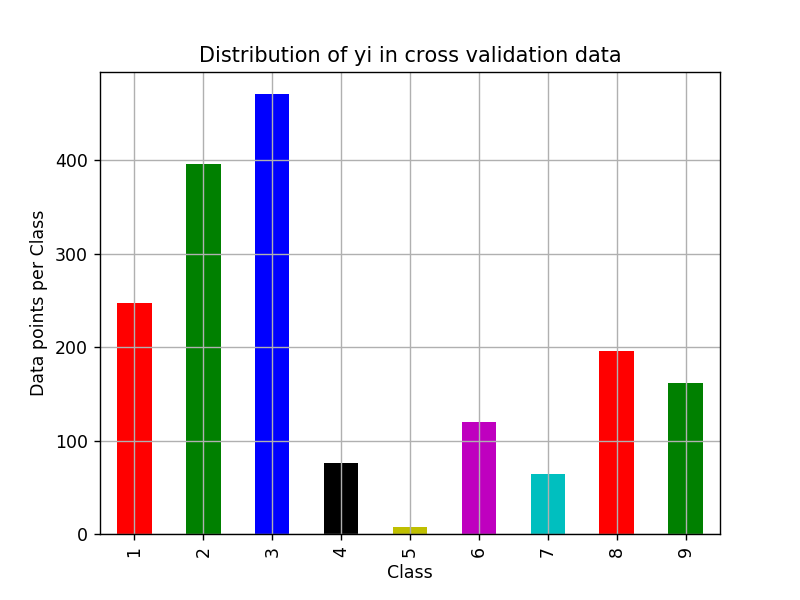

Number of data points in class 3 : 471 ( 27.085 %)
Number of data points in class 2 : 396 ( 22.772 %)
Number of data points in class 1 : 247 ( 14.204 %)
Number of data points in class 8 : 196 ( 11.271 %)
Number of data points in class 9 : 162 ( 9.316 %)
Number of data points in class 6 : 120 ( 6.901 %)
Number of data points in class 4 : 76 ( 4.37 %)
Number of data points in class 7 : 64 ( 3.68 %)
Number of data points in class 5 : 7 ( 0.403 %)


In [ ]:

train_class_distribution = y_train.value_counts().sortlevel()
test_class_distribution = y_test.value_counts().sortlevel()
cv_class_distribution = y_cv.value_counts().sortlevel()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/y_train.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/y_test.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/y_cv.shape[0]*100), 3), '%)')


In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

<h1>Machine Learning Models</h1>

<h3> Random Model</h3>

Log loss on Cross Validation Data using Random Model 2.45615644965
Log loss on Test Data using Random Model 2.48503905509
Number of misclassified points  88.5004599816
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


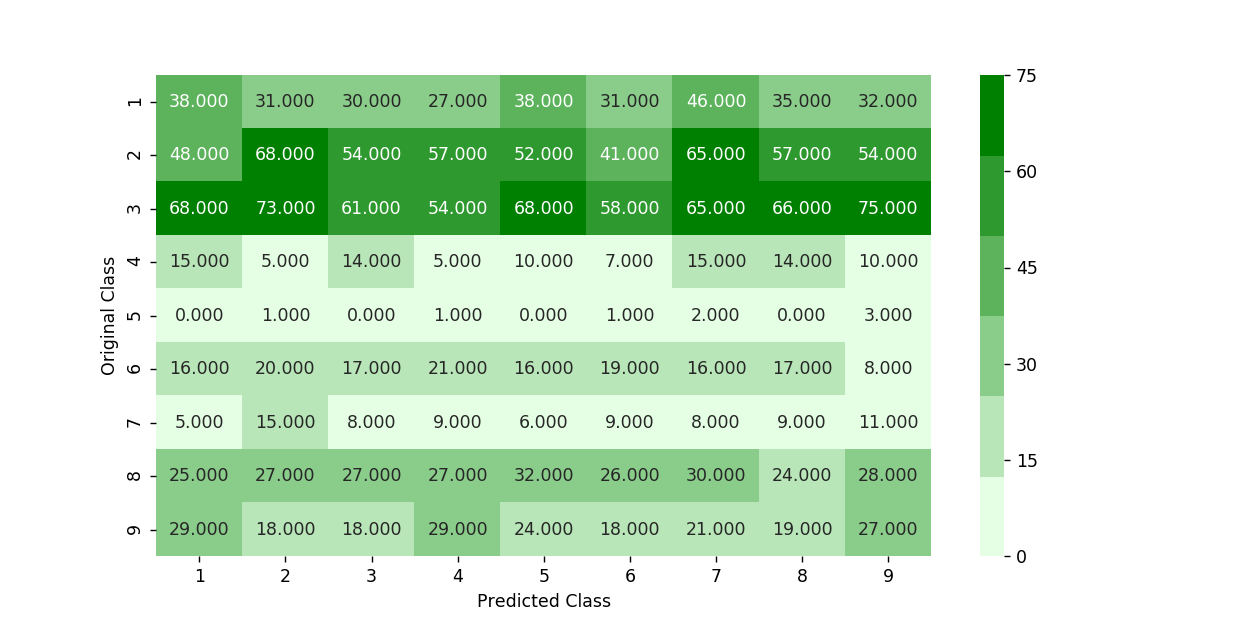

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


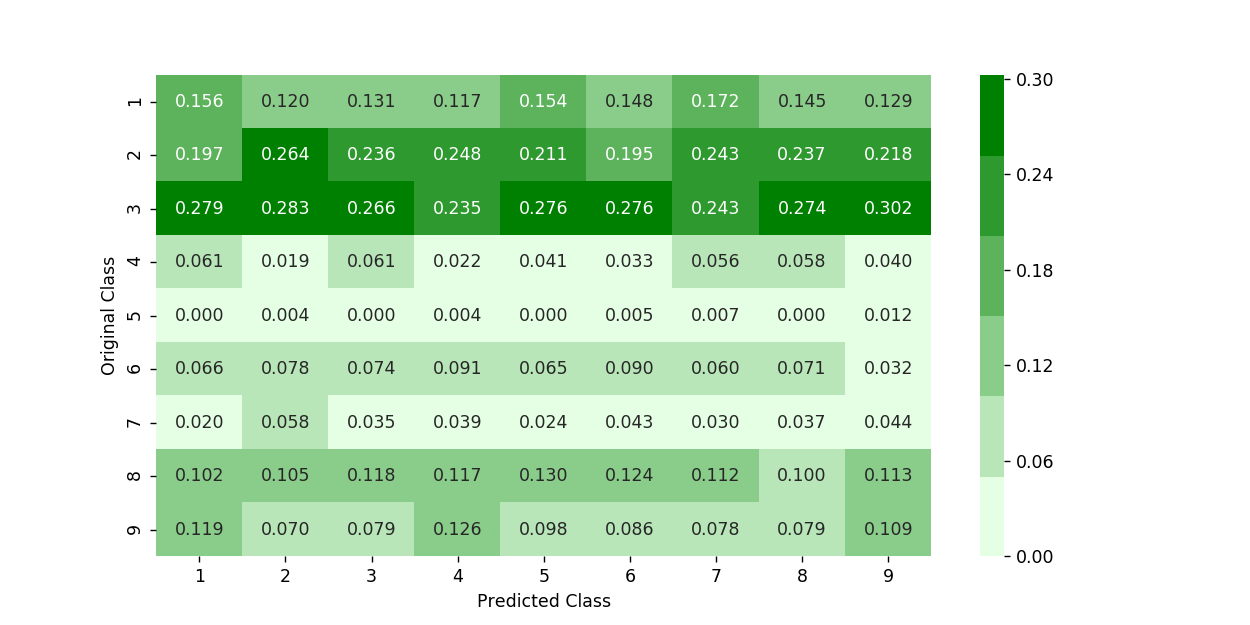

Sum of columns in precision matrix [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


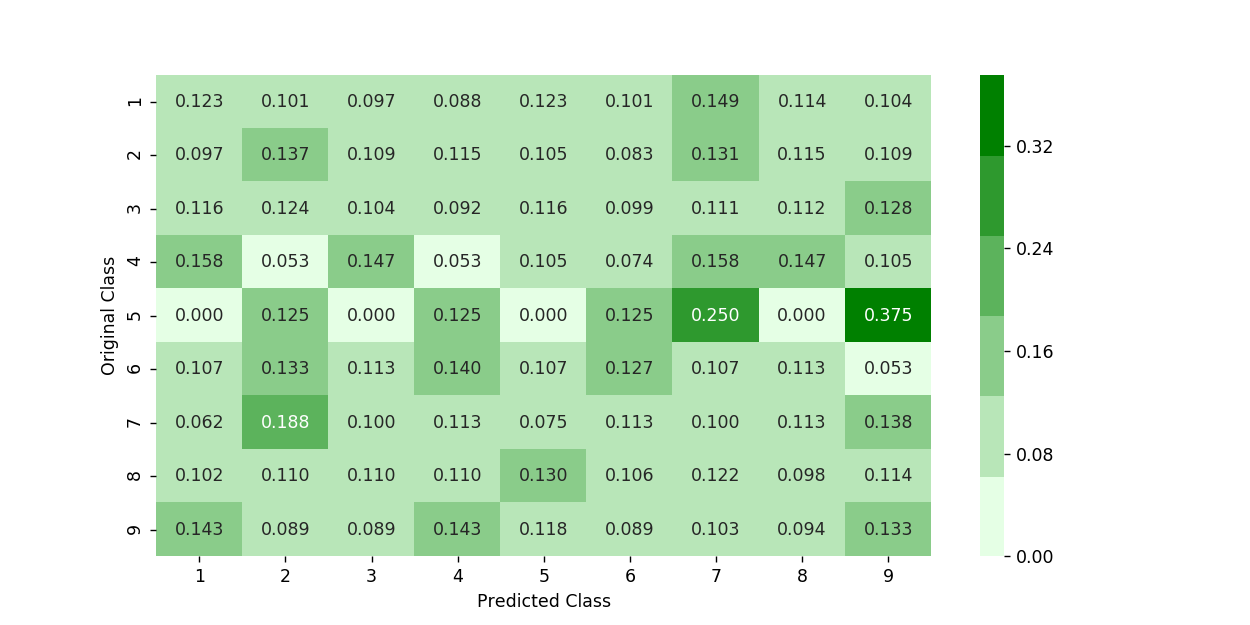

Sum of rows in precision matrix [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [ ]:


test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

<h3>K Nearest Neighbour Classification</h3>

log_loss for k =  1 is 0.225386237304
log_loss for k =  3 is 0.230795229168
log_loss for k =  5 is 0.252421408646
log_loss for k =  7 is 0.273827486888
log_loss for k =  9 is 0.286469181555
log_loss for k =  11 is 0.29623391147
log_loss for k =  13 is 0.307551203154


<IPython.core.display.Javascript object>


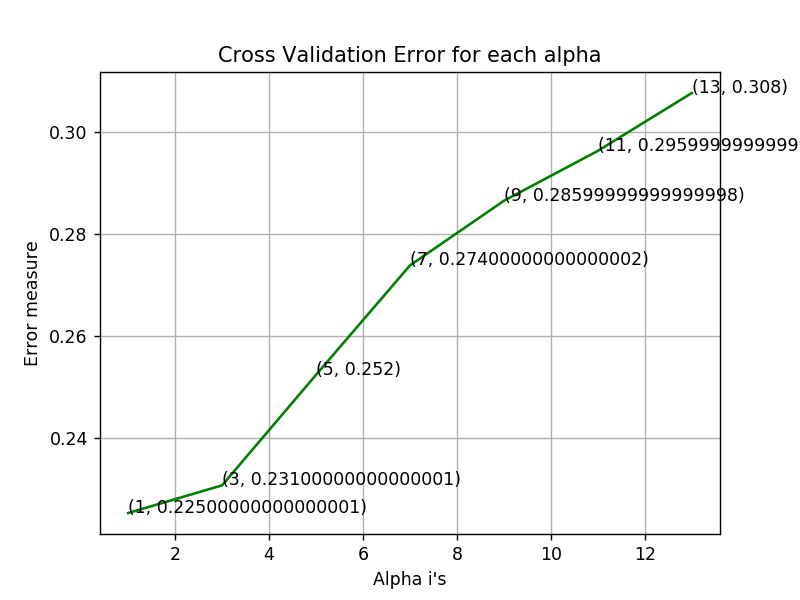

For values of best alpha =  1 The train log loss is: 0.0782947669247
For values of best alpha =  1 The cross validation log loss is: 0.225386237304
For values of best alpha =  1 The test log loss is: 0.241508604195
Number of misclassified points  4.50781968721
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


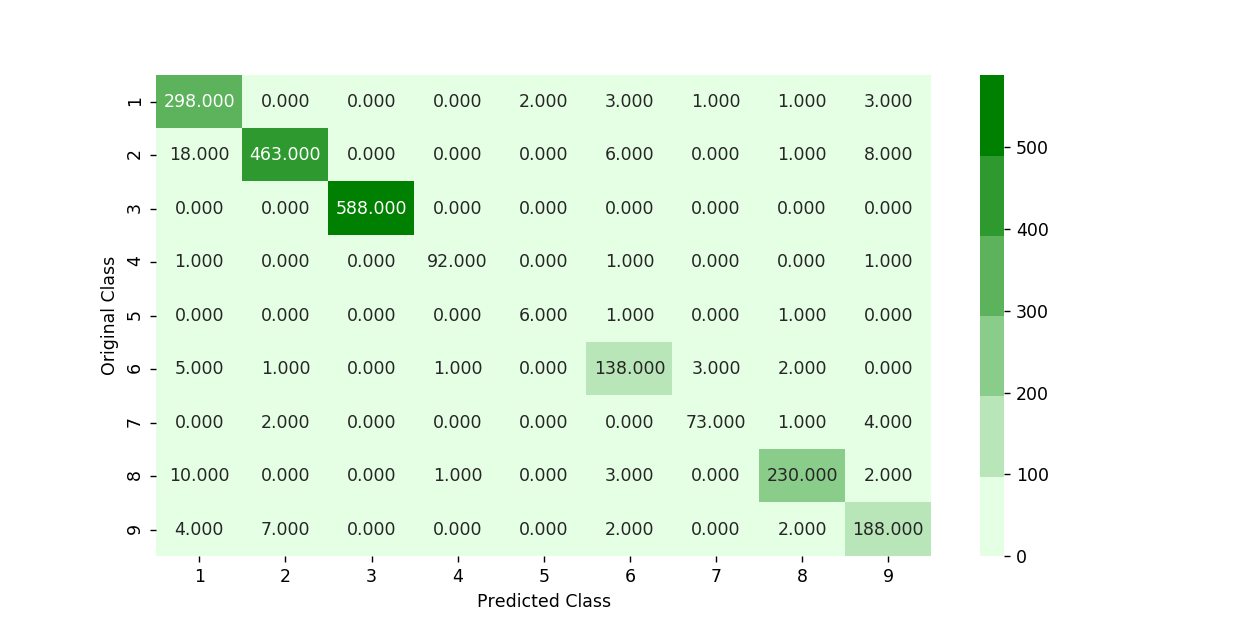

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


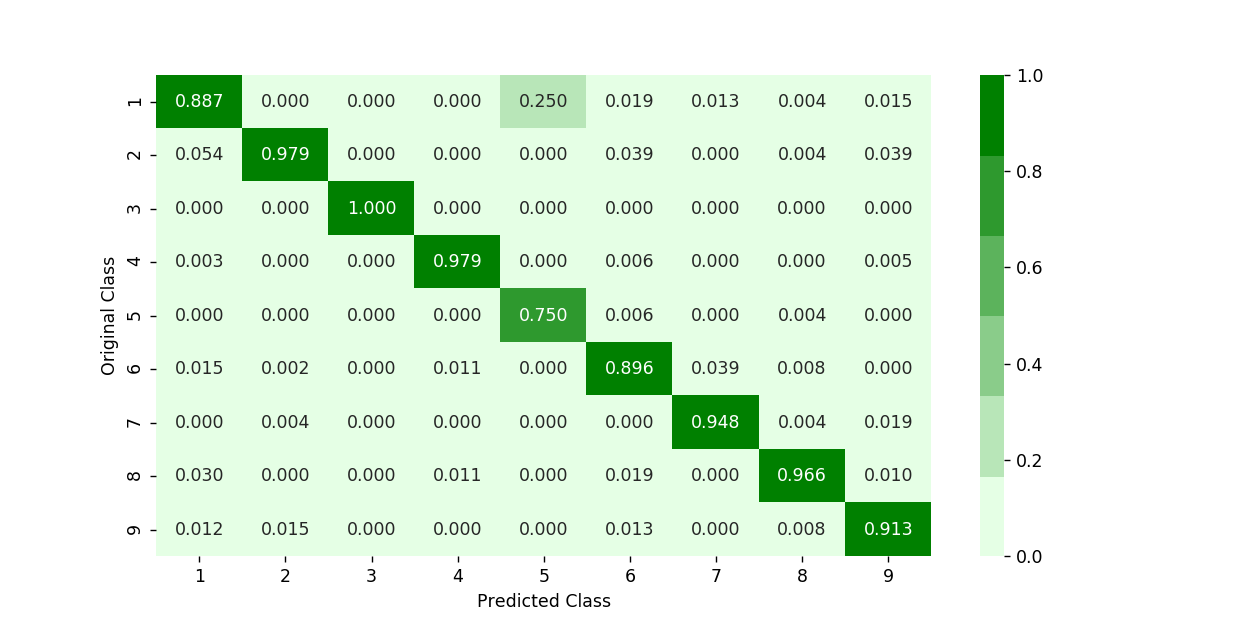

Sum of columns in precision matrix [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


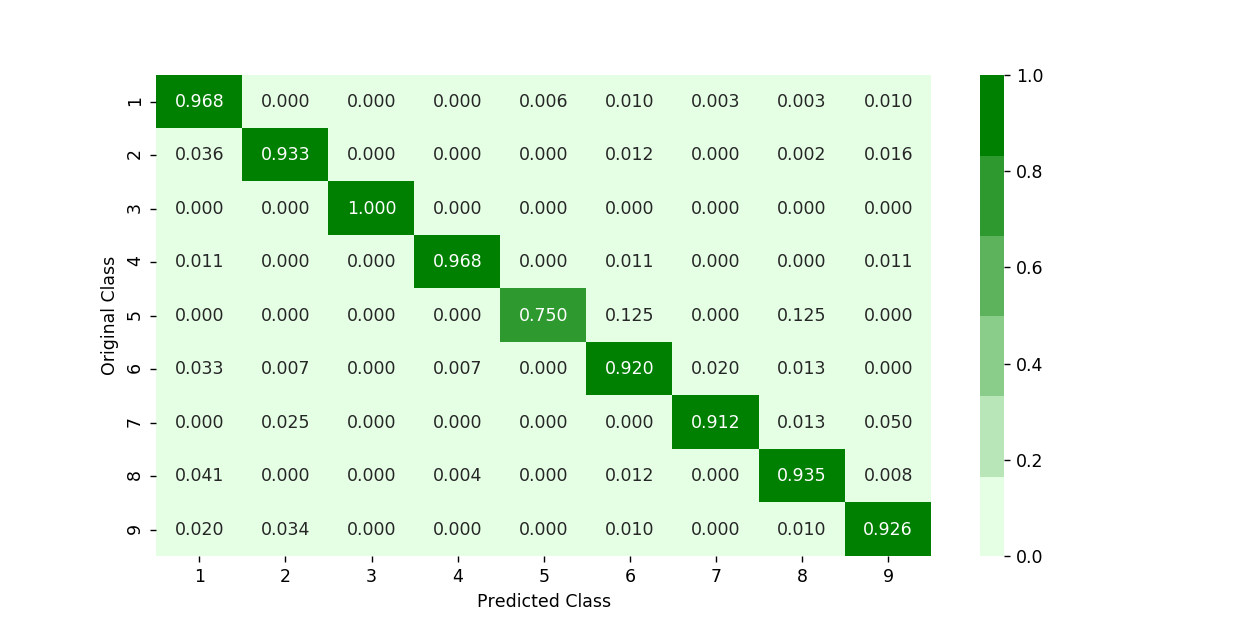

Sum of rows in precision matrix [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [ ]:

alpha = [x for x in range(1, 15, 2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h3> Logistic Regression</h3>

log_loss for c =  1e-05 is 1.56916911178
log_loss for c =  0.0001 is 1.57336384417
log_loss for c =  0.001 is 1.53598598273
log_loss for c =  0.01 is 1.01720972418
log_loss for c =  0.1 is 0.857766083873
log_loss for c =  1 is 0.711154393309
log_loss for c =  10 is 0.583929522635
log_loss for c =  100 is 0.549929846589
log_loss for c =  1000 is 0.624746769121


<IPython.core.display.Javascript object>


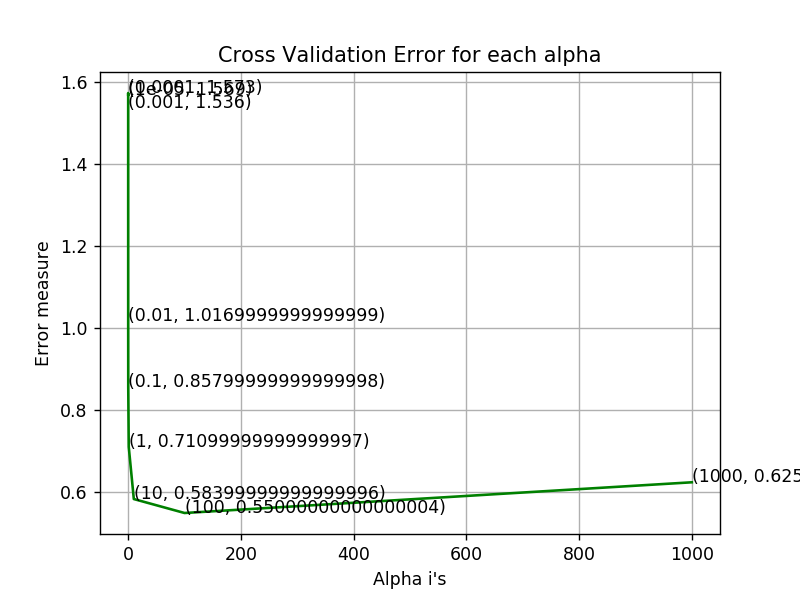

log loss for train data 0.498923428696
log loss for cv data 0.549929846589
log loss for test data 0.528347316704
Number of misclassified points  12.3275068997
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


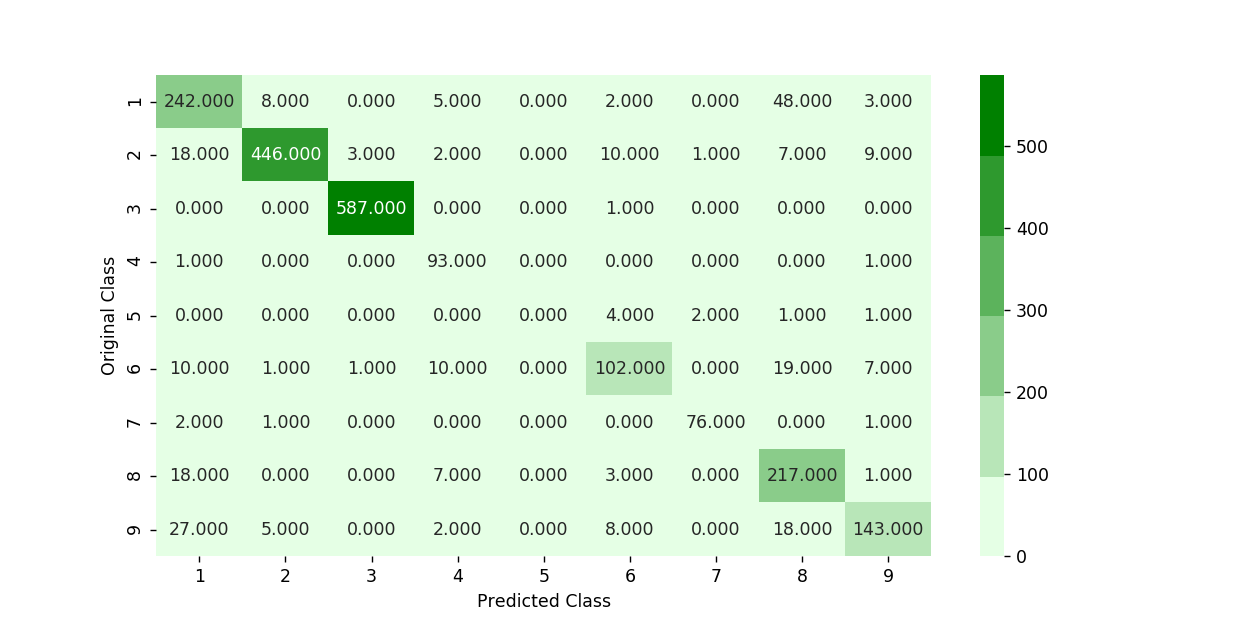

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


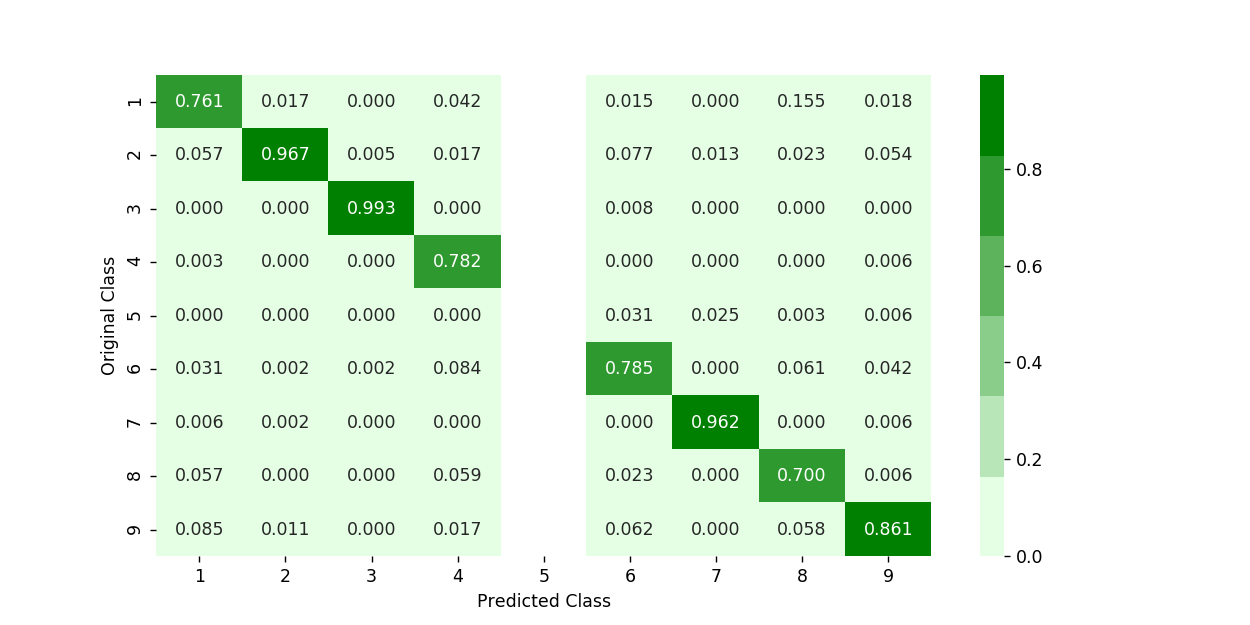

Sum of columns in precision matrix [  1.   1.   1.   1.  nan   1.   1.   1.   1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


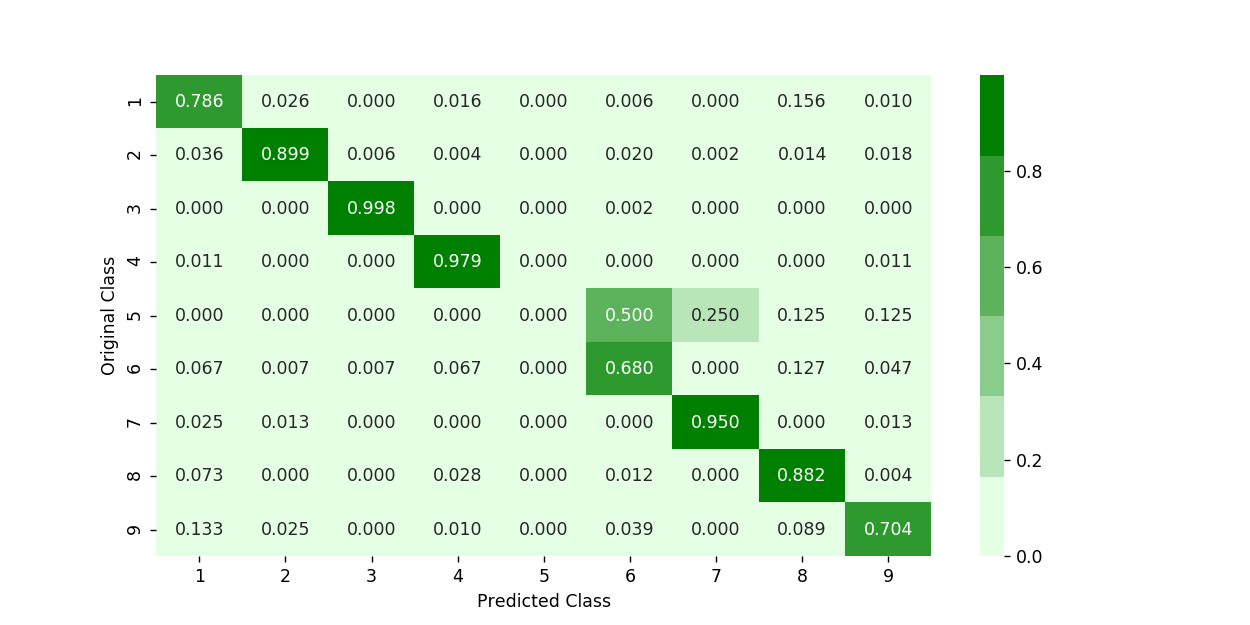

Sum of rows in precision matrix [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [ ]:

alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)
pred_y=sig_clf.predict(X_test)

predict_y = sig_clf.predict_proba(X_train)
print ('log loss for train data',log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv)
print ('log loss for cv data',log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for test data',log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h3> XgBoost Classification</h3>

log_loss for c =  10 is 0.20615980494
log_loss for c =  50 is 0.123888382365
log_loss for c =  100 is 0.099919437112
log_loss for c =  500 is 0.0931035681289
log_loss for c =  1000 is 0.0933084876012
log_loss for c =  2000 is 0.0938395690309


<IPython.core.display.Javascript object>


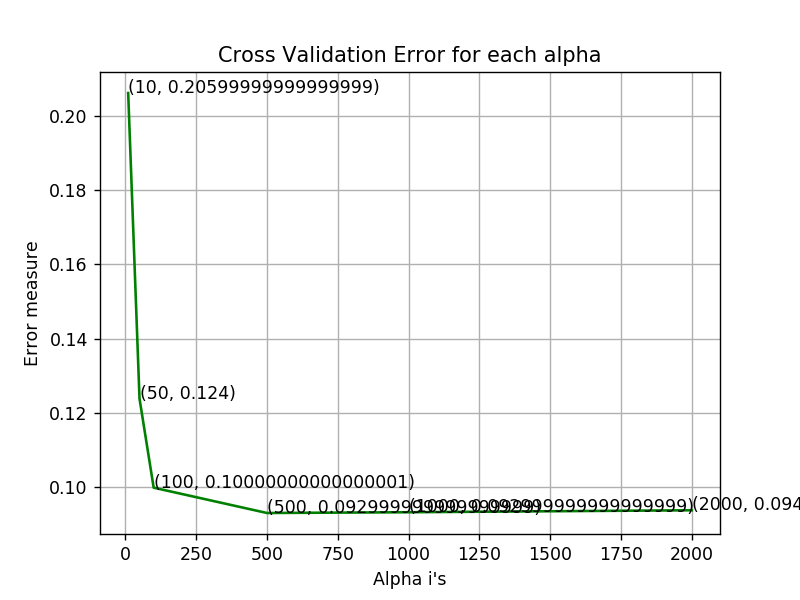

For values of best alpha =  500 The train log loss is: 0.0225231805824
For values of best alpha =  500 The cross validation log loss is: 0.0931035681289
For values of best alpha =  500 The test log loss is: 0.0792067651731
Number of misclassified points  1.24195032199
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


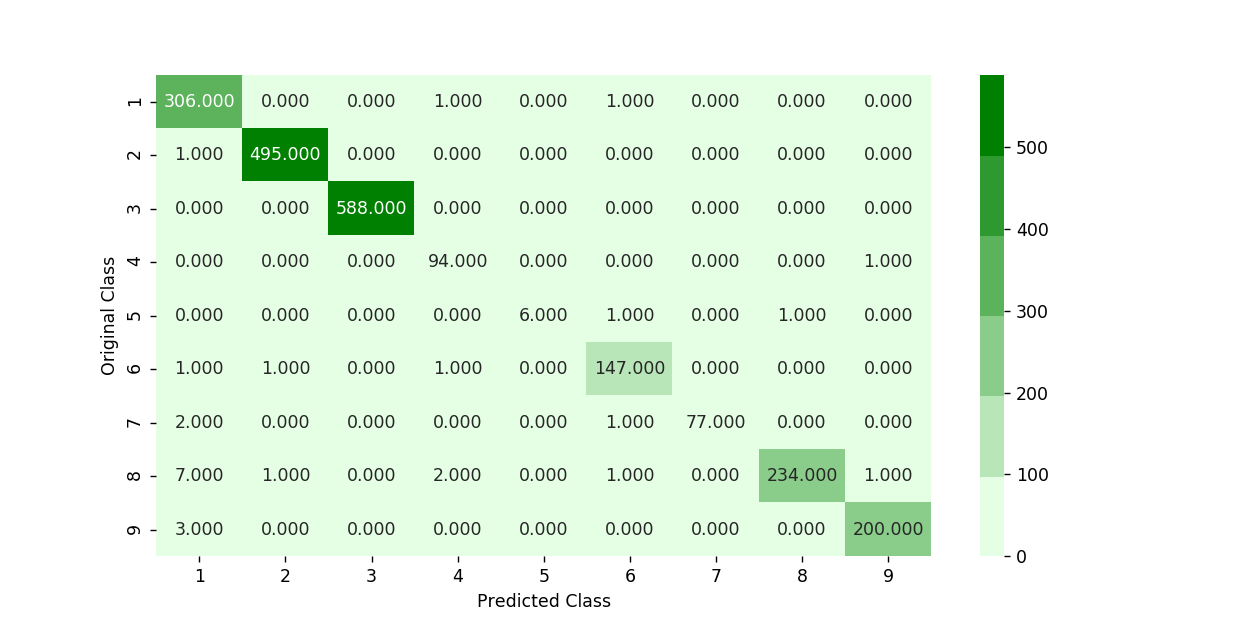

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


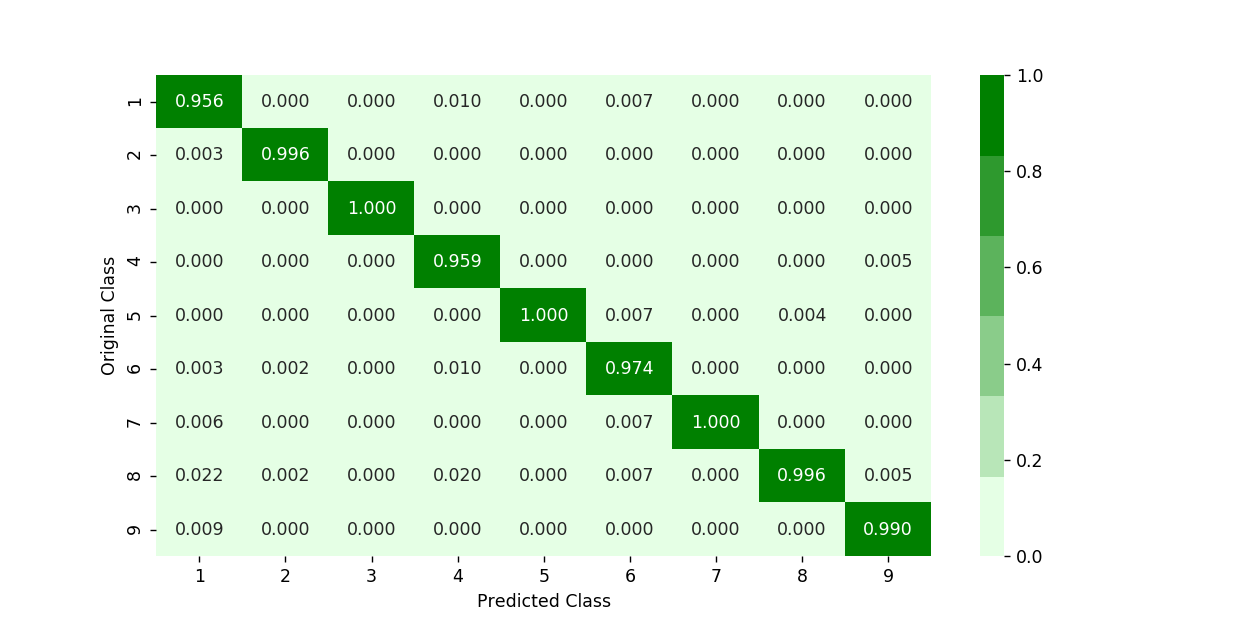

Sum of columns in precision matrix [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


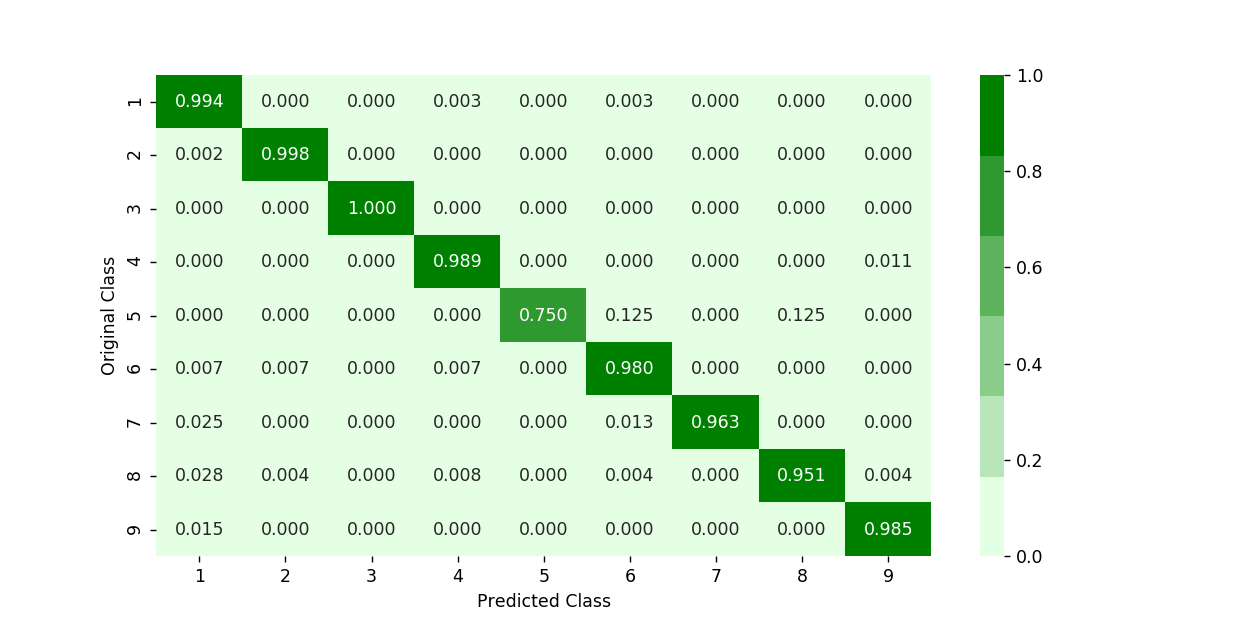

Sum of rows in precision matrix [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [ ]:

alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h2> Modeling with .asm files </h2>

<h3> Feature extraction from asm files </h3>

In [ ]:

folder_1 ='first'
folder_2 ='second'
folder_3 ='third'
folder_4 ='fourth'
folder_5 ='fifth'
folder_6 = 'output'
for i in [folder_1,folder_2,folder_3,folder_4,folder_5,folder_6]:
    if not os.path.isdir(i):
        os.makedirs(i)

source='train/'
files = os.listdir('train')
ID=df['Id'].tolist()
data=range(0,10868)
r.shuffle(data)
count=0
for i in range(0,10868):
    if i % 5==0:
        shutil.move(source+files[data[i]],'first')
    elif i%5==1:
        shutil.move(source+files[data[i]],'second')
    elif i%5 ==2:
        shutil.move(source+files[data[i]],'thrid')
    elif i%5 ==3:
        shutil.move(source+files[data[i]],'fourth')
    elif i%5==4:
        shutil.move(source+files[data[i]],'fifth')

In [ ]:


def firstprocess():
    
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
  
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
   
    keywords = ['.dll','std::',':dword']
   
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\asmsmallfile.txt","w+")
    files = os.listdir('first')
    for f in files:
        #filling the values with zeros into the arrays
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        # https://docs.python.org/3/library/codecs.html#codecs.ignore_errors
        # https://docs.python.org/3/library/codecs.html#codecs.Codec.encode
        with codecs.open('first/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                # https://www.tutorialspoint.com/python3/string_rstrip.htm
                line=lines.rstrip().split()
                l=line[0]
                #counting the prefixs in each and every line
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                #counting the opcodes in each and every line
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                #counting registers in the line
                for i in range(len(registers)):
                    for li in line:
                        # we will use registers only in 'text' and 'CODE' segments
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                #counting keywords in the line
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        #pushing the values into the file after reading whole file
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()


#same as above 
def secondprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\mediumasmfile.txt","w+")
    files = os.listdir('second')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        with codecs.open('second/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()

# same as smallprocess() functions
def thirdprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\largeasmfile.txt","w+")
    files = os.listdir('thrid')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        with codecs.open('thrid/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()


def fourthprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\hugeasmfile.txt","w+")
    files = os.listdir('fourth/')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        with codecs.open('fourth/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()


def fifthprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\trainasmfile.txt","w+")
    files = os.listdir('fifth/')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        with codecs.open('fifth/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()


def main():
    
    manager=multiprocessing.Manager() 	
    p1=Process(target=firstprocess)
    p2=Process(target=secondprocess)
    p3=Process(target=thirdprocess)
    p4=Process(target=fourthprocess)
    p5=Process(target=fifthprocess)
    #p1.start() is used to start the thread execution
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    p5.start()
    #After completion all the threads are joined
    p1.join()
    p2.join()
    p3.join()
    p4.join()
    p5.join()

if __name__=="__main__":
    main()

In [ ]:

dfasm=pd.read_csv("asmoutputfile.csv")
Y.columns = ['ID', 'Class']
result_asm = pd.merge(dfasm, Y,on='ID', how='left')
result_asm.head()

ID  HEADER:  .text:  .Pav:  .idata:  .data:  .bss:  \
0  01kcPWA9K2BOxQeS5Rju       19     744      0      127      57      0   
1  1E93CpP60RHFNiT5Qfvn       17     838      0      103      49      0   
2  3ekVow2ajZHbTnBcsDfX       17     427      0       50      43      0   
3  3X2nY7iQaPBIWDrAZqJe       17     227      0       43      19      0   
4  46OZzdsSKDCFV8h7XWxf       17     402      0       59     170      0   

   .rdata:  .edata:  .rsrc:  ...    edx  esi  eax  ebx  ecx  edi  ebp  esp  \
0      323        0       3  ...     18   66   15   43   83    0   17   48   
1        0        0       3  ...     18   29   48   82   12    0   14    0   
2      145        0       3  ...     13   42   10   67   14    0   11    0   
3        0        0       3  ...      6    8   14    7    2    0    8    0   
4        0        0       3  ...     12    9   18   29    5    0   11    0   

   eip  Class  
0   29      1  
1   20      1  
2    9      1  
3    6      1  
4   11      1  

[5 rows x 53 columns]

<h4> Files sizes of each .asm file </h4>

In [ ]:
#file sizes of byte files

files=os.listdir('asmFiles')
filenames=Y['ID'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('asmFiles/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
asm_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
print (asm_size_byte.head())

   Class                    ID       size
0      9  01azqd4InC7m9JpocGv5  56.229886
1      2  01IsoiSMh5gxyDYTl4CB  13.999378
2      9  01jsnpXSAlgw6aPeDxrU   8.507785
3      1  01kcPWA9K2BOxQeS5Rju   0.078190
4      8  01SuzwMJEIXsK7A8dQbl   0.996723


<h4> Distribution of .asm file sizes</h4>

<IPython.core.display.Javascript object>


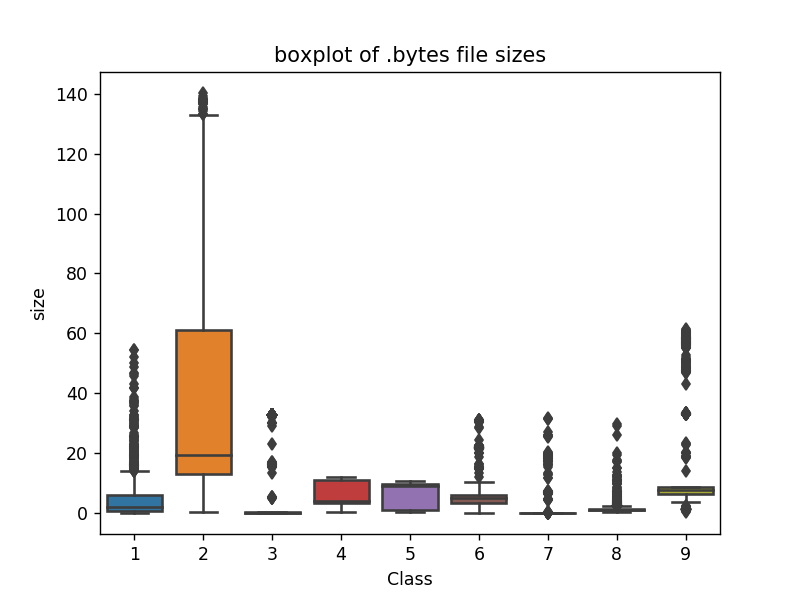

In [ ]:
#boxplot of asm files
ax = sns.boxplot(x="Class", y="size", data=asm_size_byte)
plt.title("boxplot of .bytes file sizes")
plt.show()

In [ ]:
# add the file size feature to previous extracted features
print(result_asm.shape)
print(asm_size_byte.shape)
result_asm = pd.merge(result_asm, asm_size_byte.drop(['Class'], axis=1),on='ID', how='left')
result_asm.head()

(10868, 53)
(10868, 3)


ID  HEADER:  .text:  .Pav:  .idata:  .data:  .bss:  \
0  01kcPWA9K2BOxQeS5Rju       19     744      0      127      57      0   
1  1E93CpP60RHFNiT5Qfvn       17     838      0      103      49      0   
2  3ekVow2ajZHbTnBcsDfX       17     427      0       50      43      0   
3  3X2nY7iQaPBIWDrAZqJe       17     227      0       43      19      0   
4  46OZzdsSKDCFV8h7XWxf       17     402      0       59     170      0   

   .rdata:  .edata:  .rsrc:    ...     esi  eax  ebx  ecx  edi  ebp  esp  eip  \
0      323        0       3    ...      66   15   43   83    0   17   48   29   
1        0        0       3    ...      29   48   82   12    0   14    0   20   
2      145        0       3    ...      42   10   67   14    0   11    0    9   
3        0        0       3    ...       8   14    7    2    0    8    0    6   
4        0        0       3    ...       9   18   29    5    0   11    0   11   

   Class      size  
0      1  0.078190  
1      1  0.063400  
2      1  0.041695  
3      1  0.018757  
4      1  0.037567  

[5 rows x 54 columns]

In [ ]:
# we normalize the data each column 
result_asm = normalize(result_asm)
result_asm.head()

ID   HEADER:    .text:  .Pav:   .idata:    .data:  .bss:  \
0  01kcPWA9K2BOxQeS5Rju  0.107345  0.001092    0.0  0.000761  0.000023    0.0   
1  1E93CpP60RHFNiT5Qfvn  0.096045  0.001230    0.0  0.000617  0.000019    0.0   
2  3ekVow2ajZHbTnBcsDfX  0.096045  0.000627    0.0  0.000300  0.000017    0.0   
3  3X2nY7iQaPBIWDrAZqJe  0.096045  0.000333    0.0  0.000258  0.000008    0.0   
4  46OZzdsSKDCFV8h7XWxf  0.096045  0.000590    0.0  0.000353  0.000068    0.0   

    .rdata:  .edata:    .rsrc:    ...          esi       eax       ebx  \
0  0.000084      0.0  0.000072    ...     0.000746  0.000301  0.000360   
1  0.000000      0.0  0.000072    ...     0.000328  0.000965  0.000686   
2  0.000038      0.0  0.000072    ...     0.000475  0.000201  0.000560   
3  0.000000      0.0  0.000072    ...     0.000090  0.000281  0.000059   
4  0.000000      0.0  0.000072    ...     0.000102  0.000362  0.000243   

        ecx  edi       ebp       esp       eip  Class      size  
0  0.001057  0.0  0.030797  0.001468  0.003173      1  0.000432  
1  0.000153  0.0  0.025362  0.000000  0.002188      1  0.000327  
2  0.000178  0.0  0.019928  0.000000  0.000985      1  0.000172  
3  0.000025  0.0  0.014493  0.000000  0.000657      1  0.000009  
4  0.000064  0.0  0.019928  0.000000  0.001204      1  0.000143  

[5 rows x 54 columns]

<h3>  Univariate analysis on  asm file features</h3>

<IPython.core.display.Javascript object>


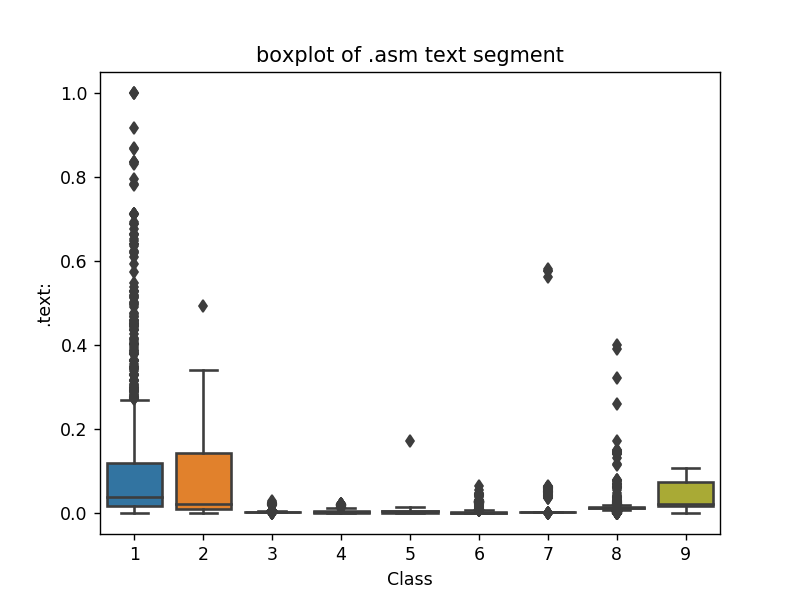

In [ ]:
ax = sns.boxplot(x="Class", y=".text:", data=result_asm)
plt.title("boxplot of .asm text segment")
plt.show()

<pre>
The plot is between Text and class 
Class 1,2 and 9 can be easly separated
</pre>

<IPython.core.display.Javascript object>


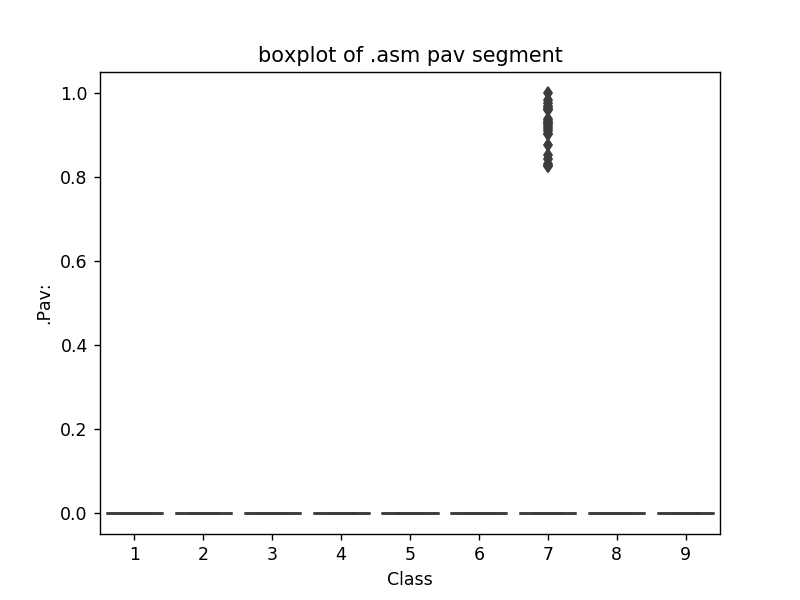

In [ ]:
ax = sns.boxplot(x="Class", y=".Pav:", data=result_asm)
plt.title("boxplot of .asm pav segment")
plt.show()

<IPython.core.display.Javascript object>


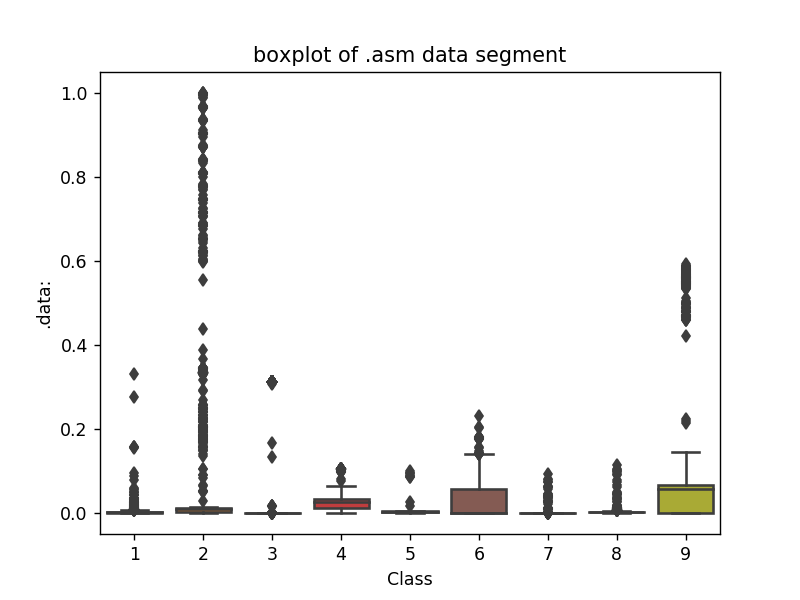

In [ ]:
ax = sns.boxplot(x="Class", y=".data:", data=result_asm)
plt.title("boxplot of .asm data segment")
plt.show()

<pre>
The plot is between data segment and class label 
class 6 and class 9 can be easily separated from given points
</pre>

<IPython.core.display.Javascript object>


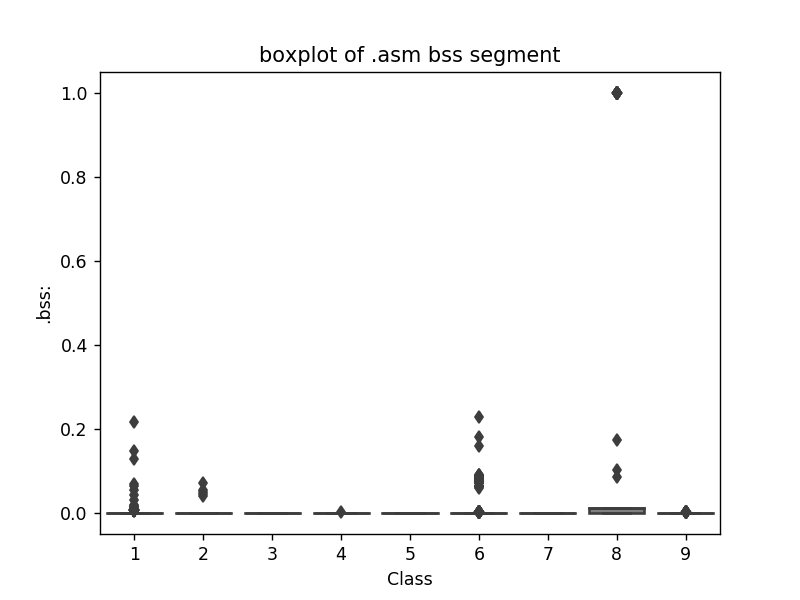

In [ ]:
ax = sns.boxplot(x="Class", y=".bss:", data=result_asm)
plt.title("boxplot of .asm bss segment")
plt.show()

<pre>
plot between bss segment and class label
very less number of files are having bss segment
</pre>

<IPython.core.display.Javascript object>


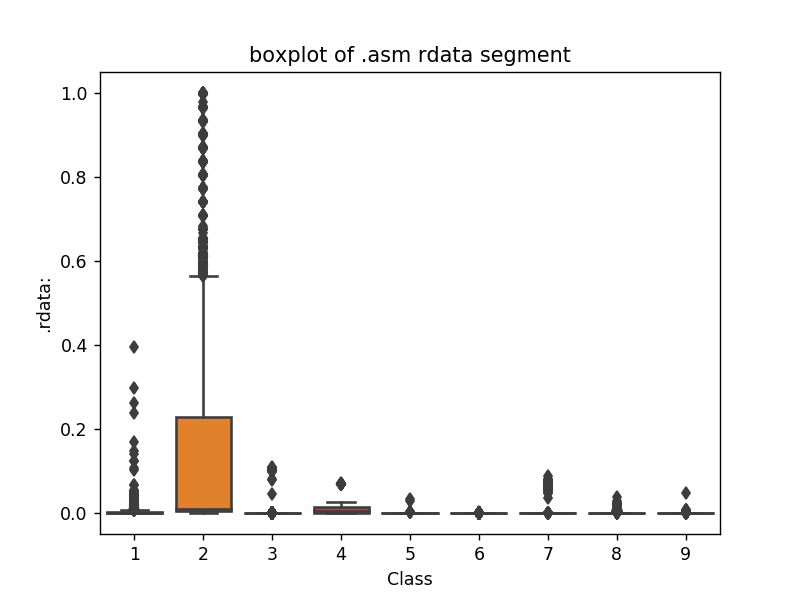

In [ ]:
ax = sns.boxplot(x="Class", y=".rdata:", data=result_asm)
plt.title("boxplot of .asm rdata segment")
plt.show()

<pre>
Plot between rdata segment and Class segment
Class 2 can be easily separated 75 pecentile files are having 1M rdata lines
</pre>

<IPython.core.display.Javascript object>


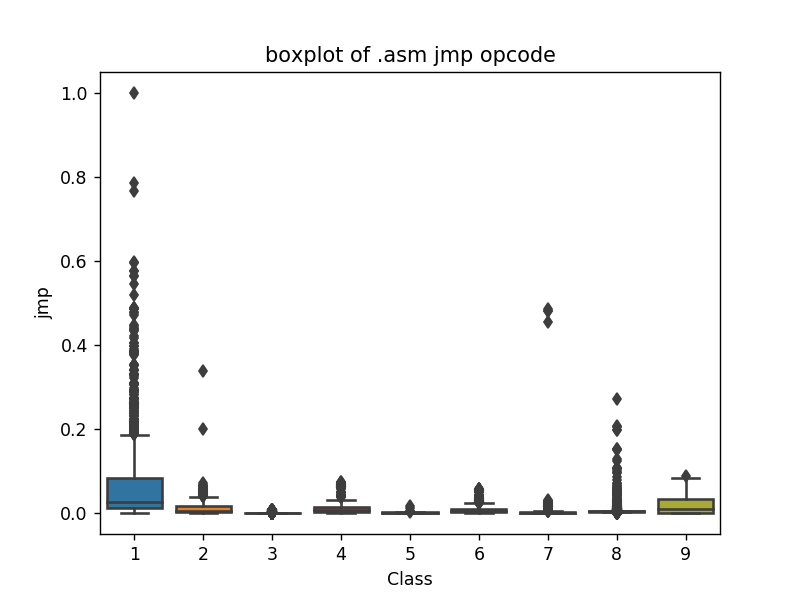

In [ ]:
ax = sns.boxplot(x="Class", y="jmp", data=result_asm)
plt.title("boxplot of .asm jmp opcode")
plt.show()

<pre>
plot between jmp and Class label
Class 1 is having frequency of 2000 approx in 75 perentile of files
</pre>

<IPython.core.display.Javascript object>


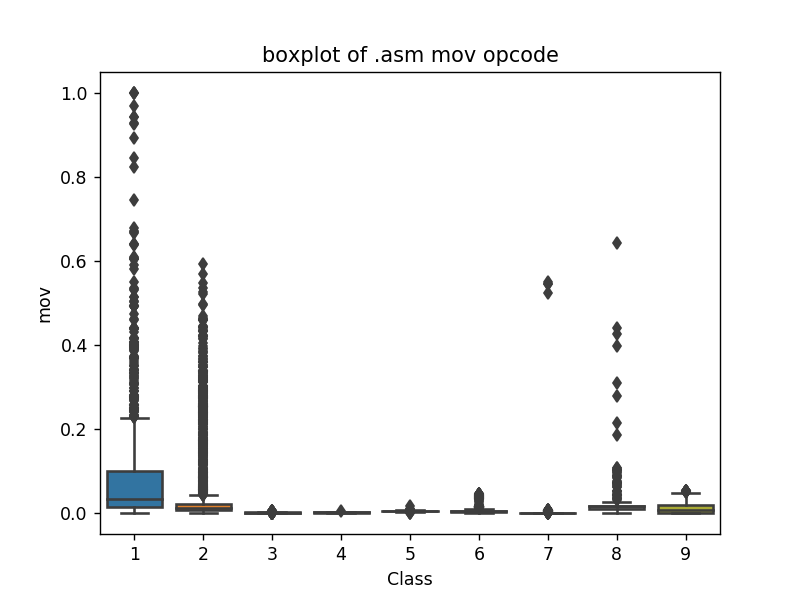

In [ ]:
ax = sns.boxplot(x="Class", y="mov", data=result_asm)
plt.title("boxplot of .asm mov opcode")
plt.show()

<pre>
plot between Class label and mov opcode
Class 1 is having frequency of 2000 approx in 75 perentile of files
</pre>

<IPython.core.display.Javascript object>


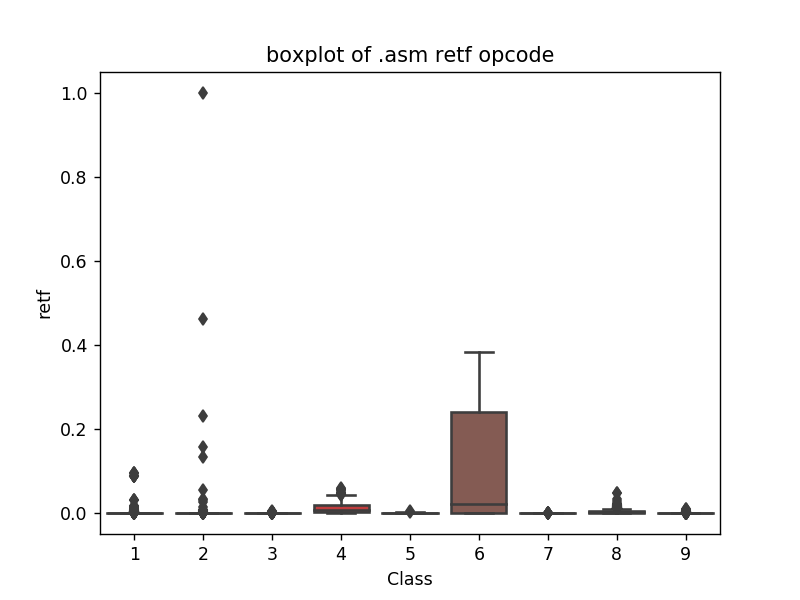

In [ ]:
ax = sns.boxplot(x="Class", y="retf", data=result_asm)
plt.title("boxplot of .asm retf opcode")
plt.show()

<pre>
plot between Class label and retf
Class 6 can be easily separated with opcode retf
The frequency of retf is approx of 250.
</pre>

<IPython.core.display.Javascript object>


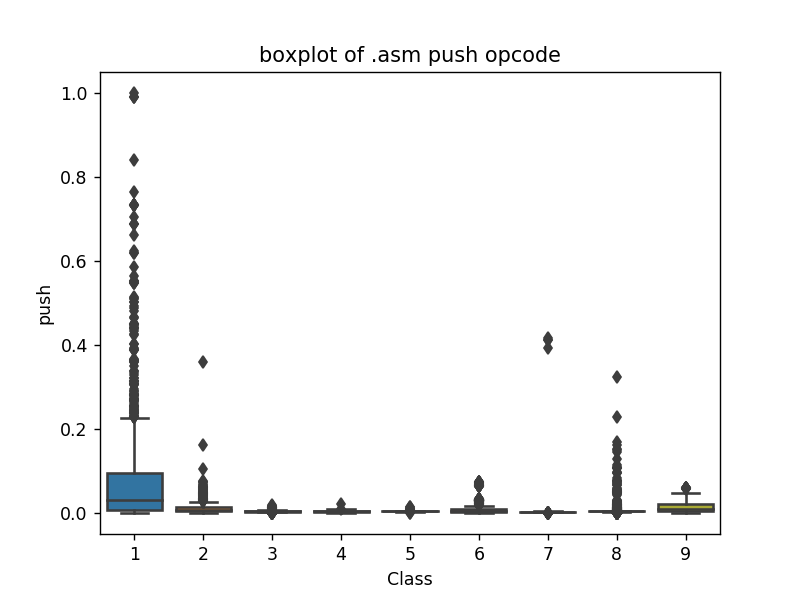

In [ ]:
ax = sns.boxplot(x="Class", y="push", data=result_asm)
plt.title("boxplot of .asm push opcode")
plt.show()

<pre>
plot between push opcode and Class label
Class 1 is having 75 precentile files with push opcodes of frequency 1000
</pre>

<h3> Multivariate Analysis on .asm file features </h3>

<IPython.core.display.Javascript object>


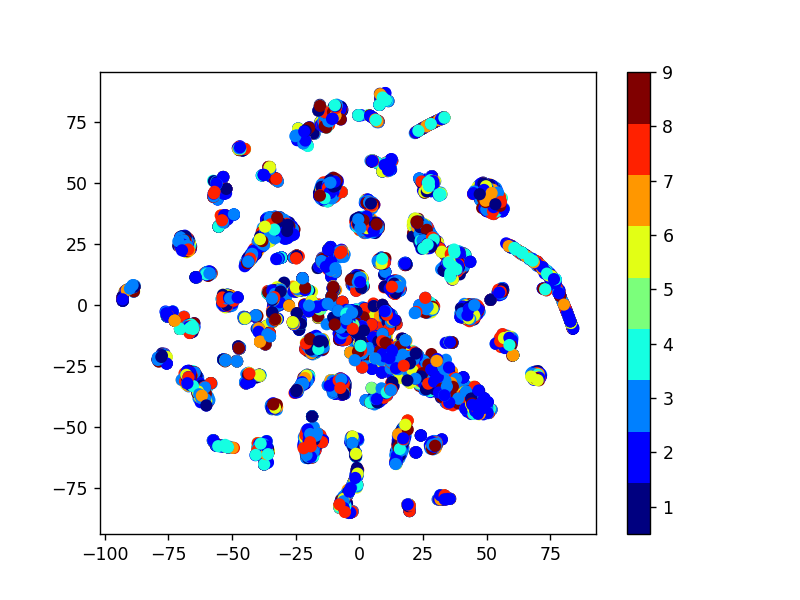

In [ ]:

xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(result_asm.drop(['ID','Class'], axis=1).fillna(0))
vis_x = results[:, 0]
vis_y = results[:, 1   ]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

<IPython.core.display.Javascript object>


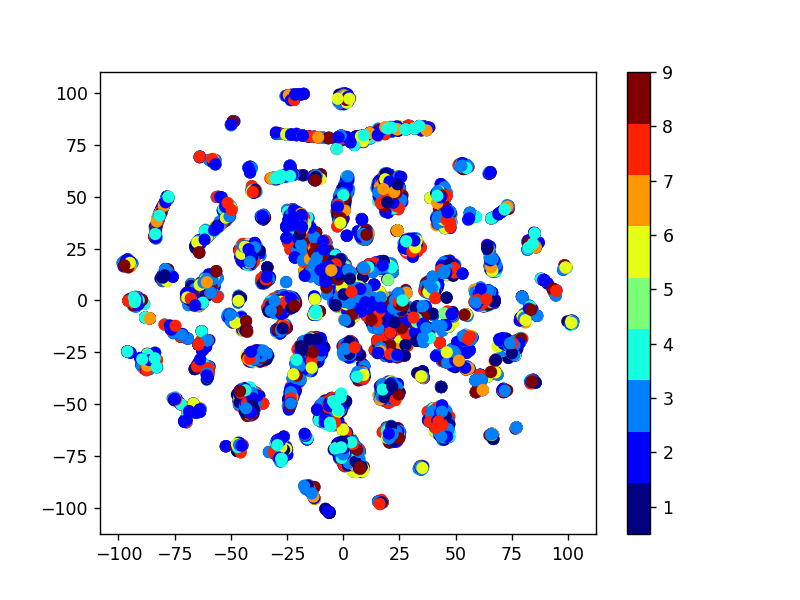

In [ ]:

xtsne=TSNE(perplexity=30)
results=xtsne.fit_transform(result_asm.drop(['ID','Class', 'rtn', '.BSS:', '.CODE','size'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

<pre>
TSNE for asm data with perplexity 50
</pre>

<h3>  Conclusion on EDA</h3>

<p>
<li>We have taken only 52 features from asm files (after reading through many blogs and research papers) </li>
<li>The univariate analysis was done only on few important features.</li>
<li>Take-aways
<ul>
<li>1. Class 3 can be easily separated because of the frequency of segments,opcodes and keywords being less </li>
<li>2. Each feature has its unique importance in separating the Class labels.</li>
</ul>
</li>
</p>

<h2>  Train and test split</h2>

In [ ]:
asm_y = result_asm['Class']
asm_x = result_asm.drop(['ID','Class','.BSS:','rtn','.CODE'], axis=1)

In [ ]:
X_train_asm, X_test_asm, y_train_asm, y_test_asm = train_test_split(asm_x,asm_y ,stratify=asm_y,test_size=0.20)
X_train_asm, X_cv_asm, y_train_asm, y_cv_asm = train_test_split(X_train_asm, y_train_asm,stratify=y_train_asm,test_size=0.20)

In [ ]:
print( X_cv_asm.isnull().all())

HEADER:    False
.text:     False
.Pav:      False
.idata:    False
.data:     False
.bss:      False
.rdata:    False
.edata:    False
.rsrc:     False
.tls:      False
.reloc:    False
jmp        False
mov        False
retf       False
push       False
pop        False
xor        False
retn       False
nop        False
sub        False
inc        False
dec        False
add        False
imul       False
xchg       False
or         False
shr        False
cmp        False
call       False
shl        False
ror        False
rol        False
jnb        False
jz         False
lea        False
movzx      False
.dll       False
std::      False
:dword     False
edx        False
esi        False
eax        False
ebx        False
ecx        False
edi        False
ebp        False
esp        False
eip        False
size       False
dtype: bool


<h2> Machine Learning models on features of .asm files</h2>

<h3>  K-Nearest Neigbors </h3>

log_loss for k =  1 is 0.104531321344
log_loss for k =  3 is 0.0958800580948
log_loss for k =  5 is 0.0995466557335
log_loss for k =  7 is 0.107227274345
log_loss for k =  9 is 0.119239543547
log_loss for k =  11 is 0.133926642781
log_loss for k =  13 is 0.147643793967
log_loss for k =  15 is 0.159439699615
log_loss for k =  17 is 0.16878376444
log_loss for k =  19 is 0.178020728839


<IPython.core.display.Javascript object>


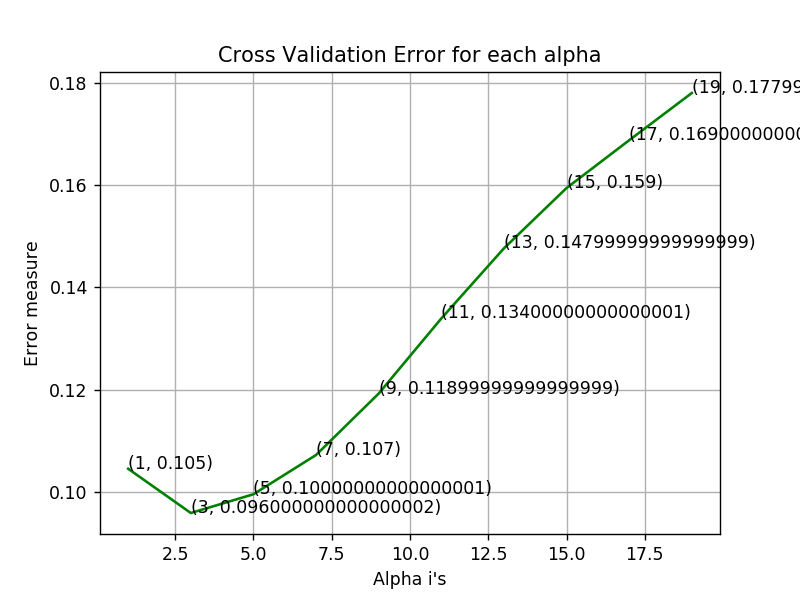

log loss for train data 0.0476773462198
log loss for cv data 0.0958800580948
log loss for test data 0.0894810720832
Number of misclassified points  2.02391904324
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


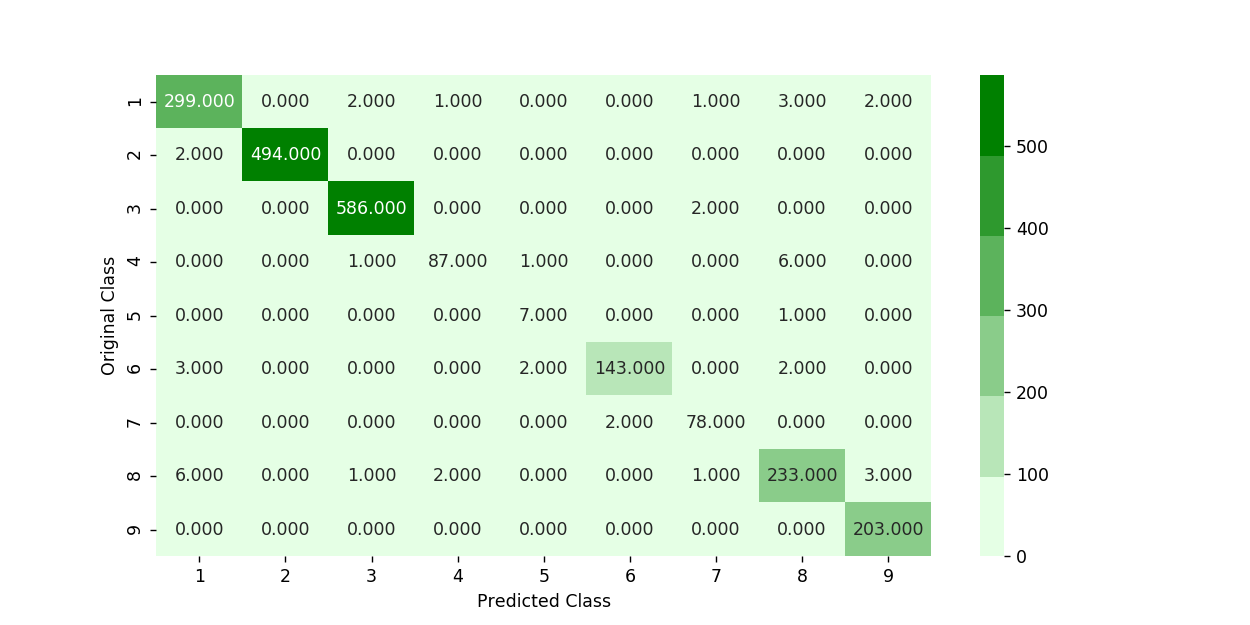

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


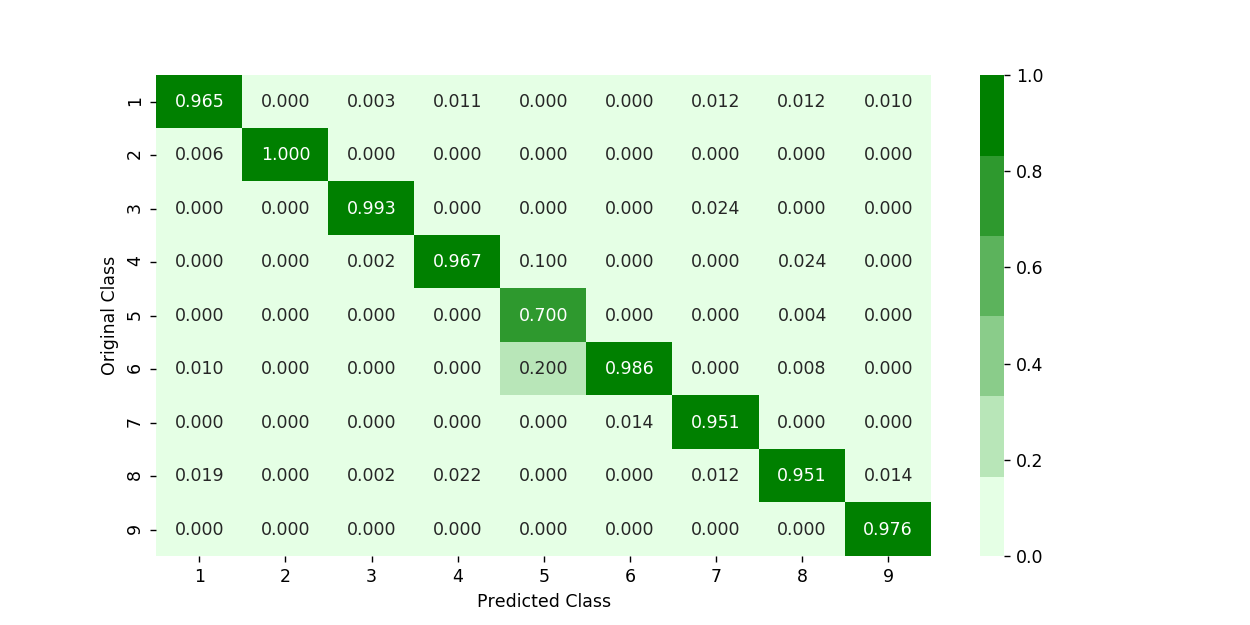

Sum of columns in precision matrix [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


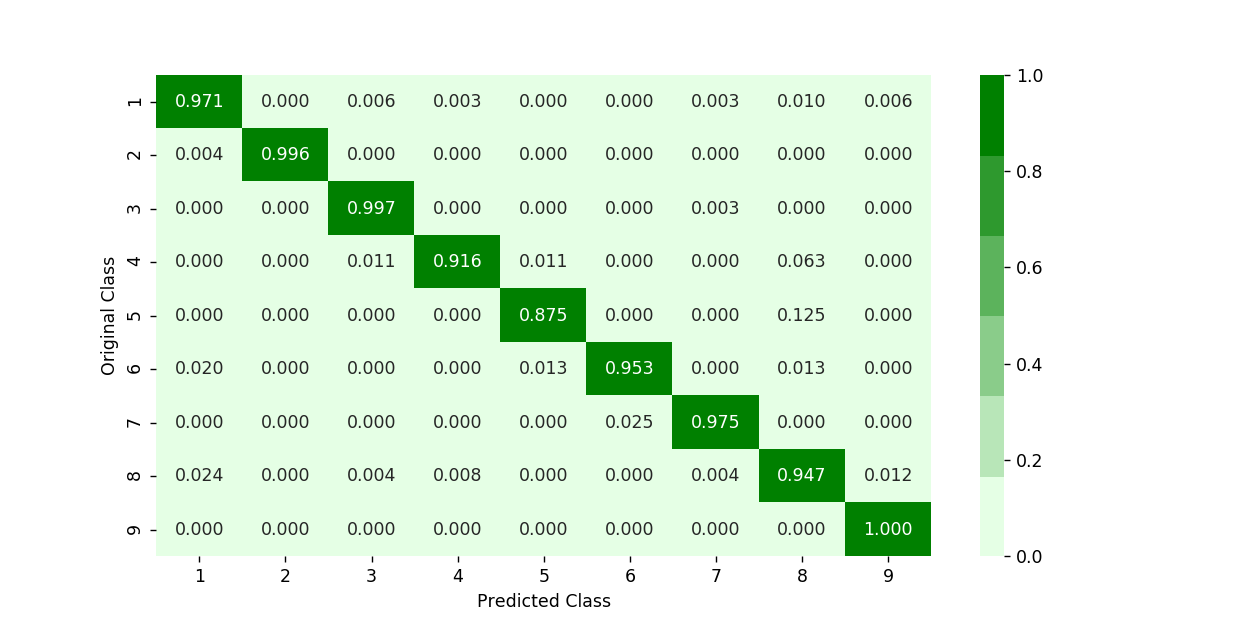

Sum of rows in precision matrix [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [ ]:

alpha = [x for x in range(1, 21,2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
pred_y=sig_clf.predict(X_test_asm)


predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',log_loss(y_train_asm, predict_y))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',log_loss(y_cv_asm, predict_y))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',log_loss(y_test_asm, predict_y))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

<h3> Logistic Regression </h3>

log_loss for c =  1e-05 is 1.58867274165
log_loss for c =  0.0001 is 1.54560797884
log_loss for c =  0.001 is 1.30137786807
log_loss for c =  0.01 is 1.33317456931
log_loss for c =  0.1 is 1.16705751378
log_loss for c =  1 is 0.757667807779
log_loss for c =  10 is 0.546533939819
log_loss for c =  100 is 0.438414998062
log_loss for c =  1000 is 0.424423536526


<IPython.core.display.Javascript object>


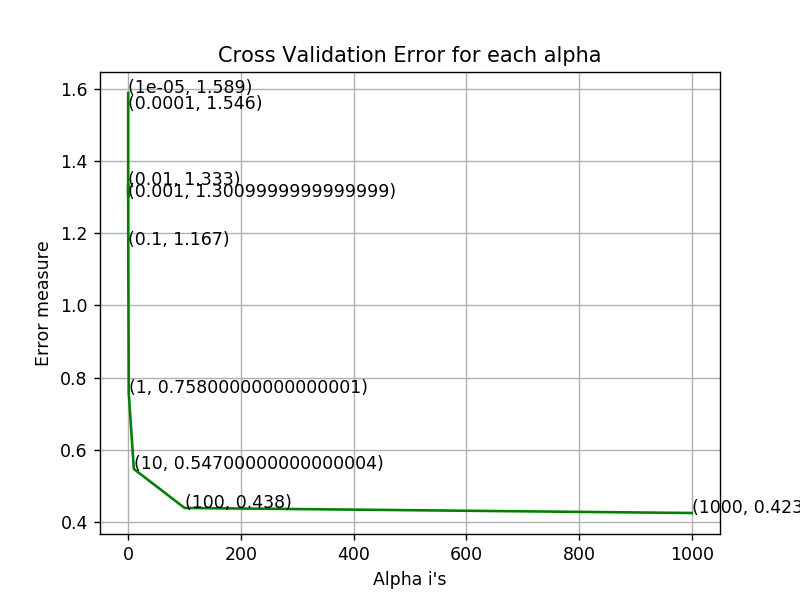

log loss for train data 0.396219394701
log loss for cv data 0.424423536526
log loss for test data 0.415685592517
Number of misclassified points  9.61361545538
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


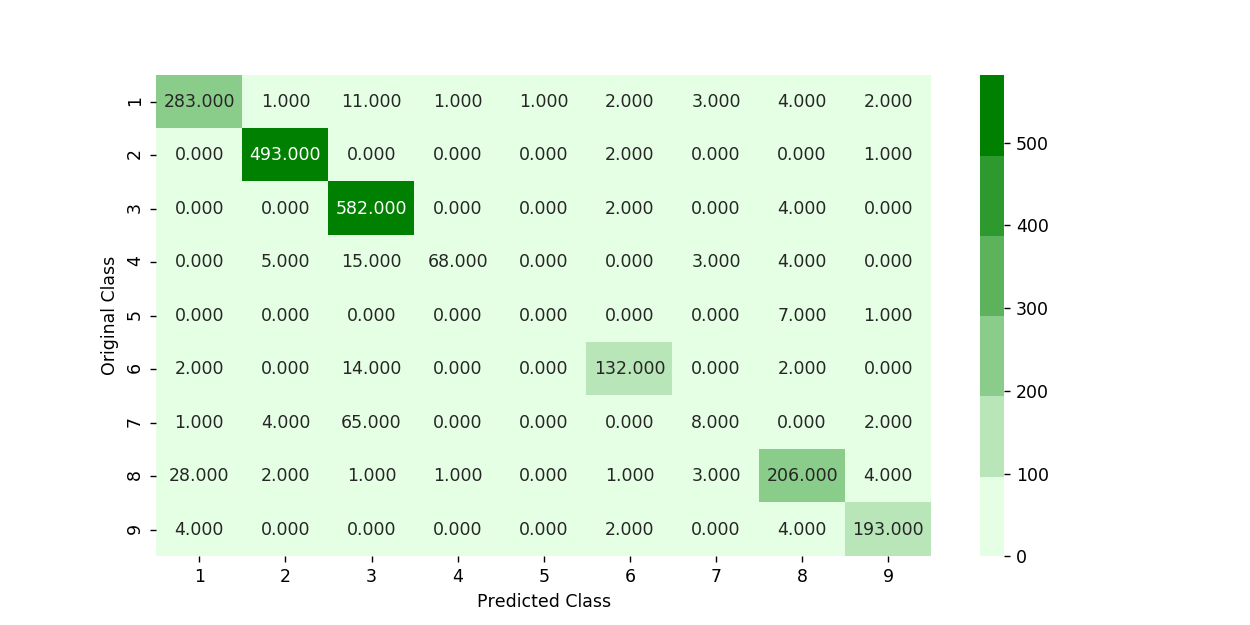

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


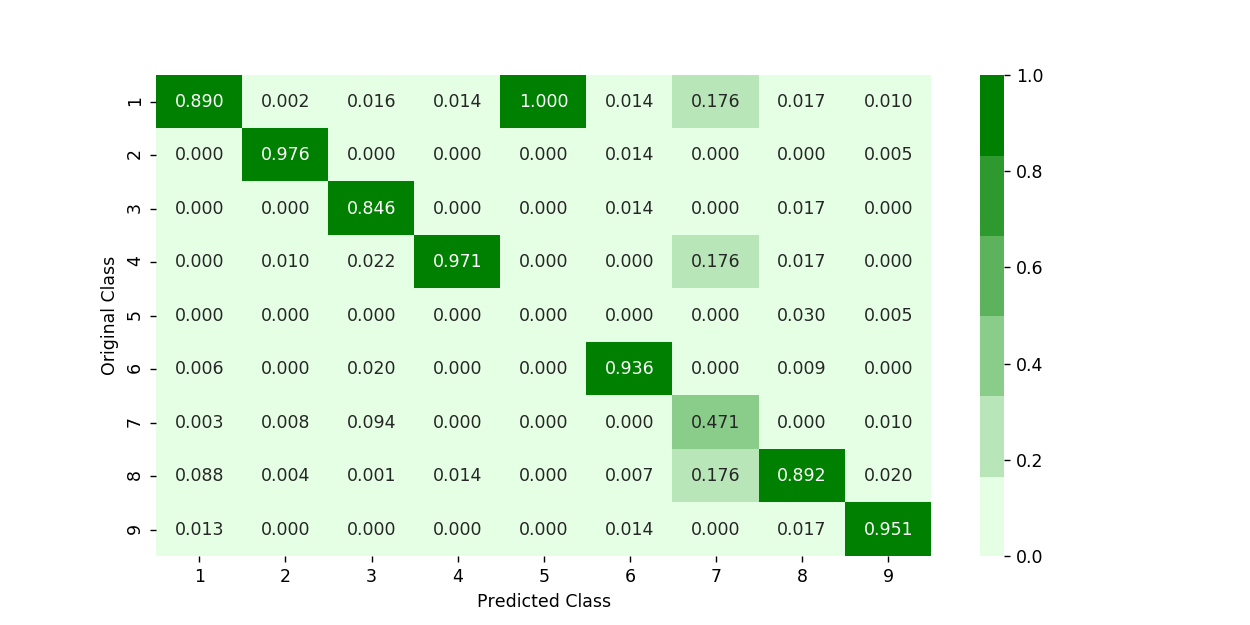

Sum of columns in precision matrix [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


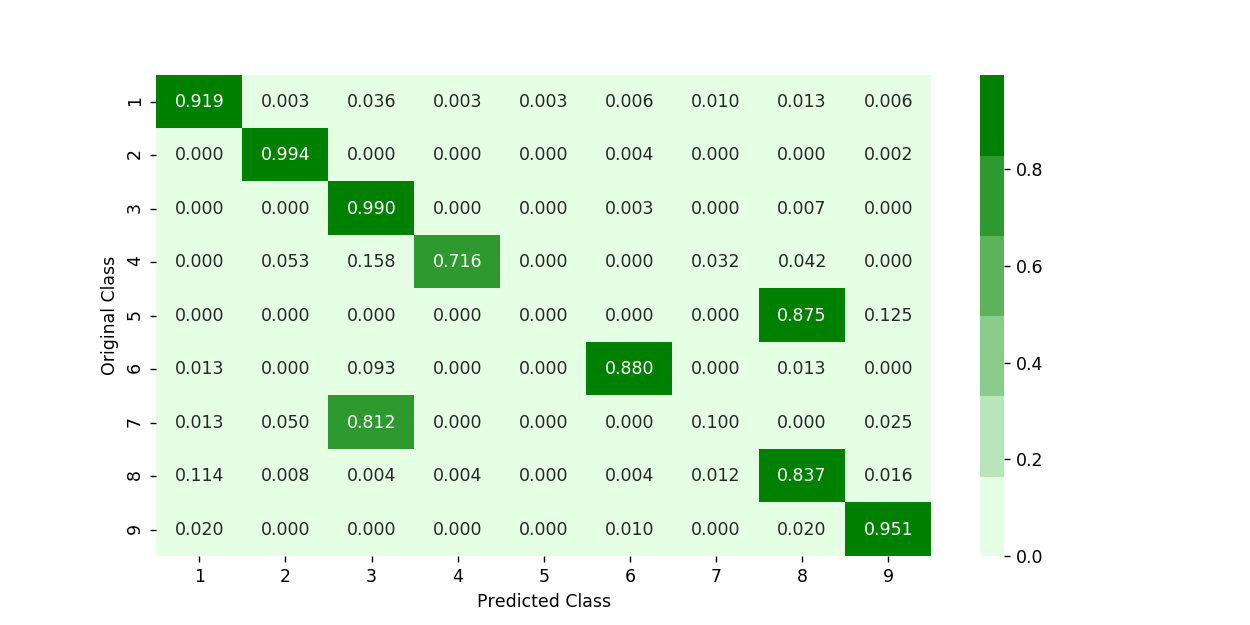

Sum of rows in precision matrix [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [ ]:

alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)

predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',(log_loss(y_train_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',(log_loss(y_cv_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',(log_loss(y_test_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

<h3>  XgBoost Classifier</h3>

log_loss for c =  10 is 0.104344888454
log_loss for c =  50 is 0.0567190635611
log_loss for c =  100 is 0.056075038646
log_loss for c =  500 is 0.057336051683
log_loss for c =  1000 is 0.0571265109903
log_loss for c =  2000 is 0.057103406781
log_loss for c =  3000 is 0.0567993215778


<IPython.core.display.Javascript object>


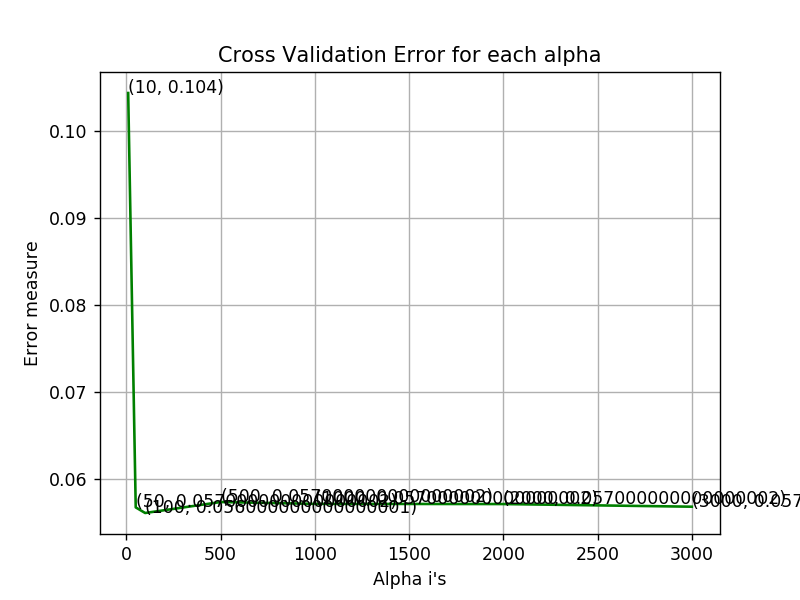

For values of best alpha =  100 The train log loss is: 0.0117883742574
For values of best alpha =  100 The cross validation log loss is: 0.056075038646
For values of best alpha =  100 The test log loss is: 0.0491647763845
Number of misclassified points  0.873965041398
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


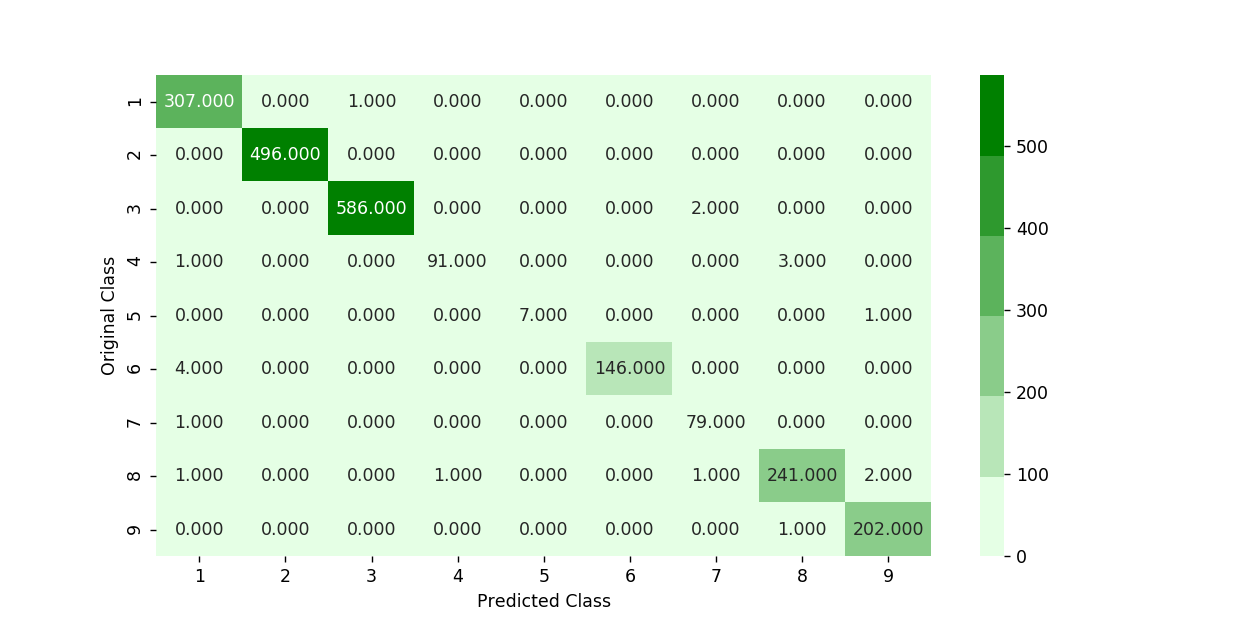

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


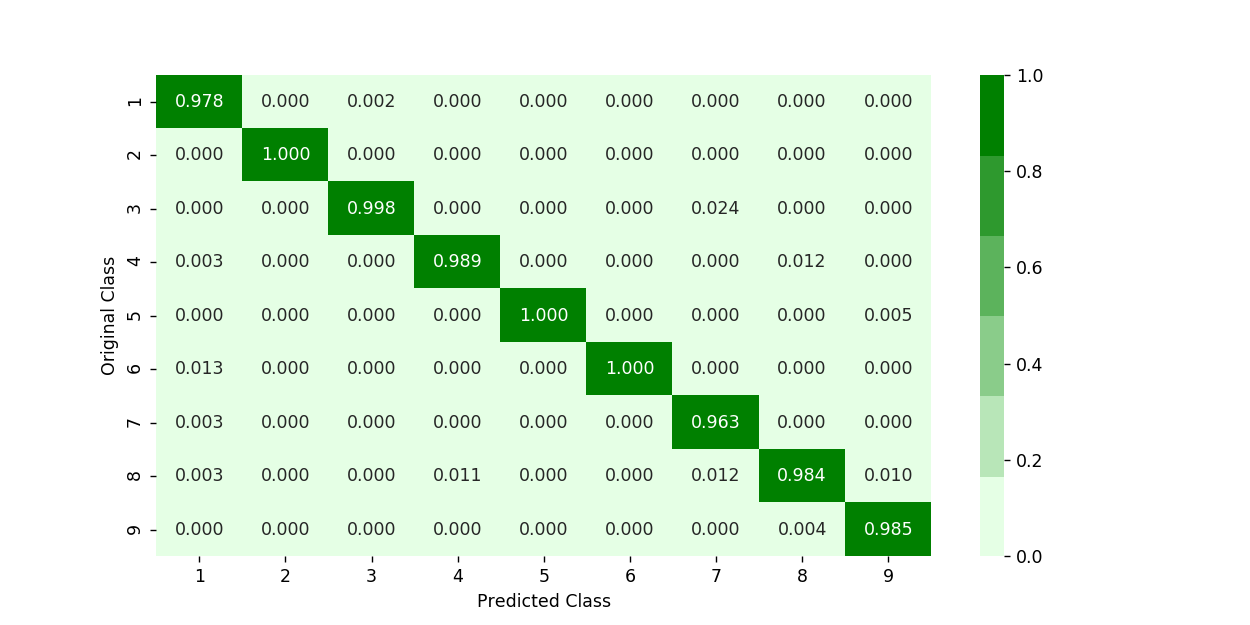

Sum of columns in precision matrix [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


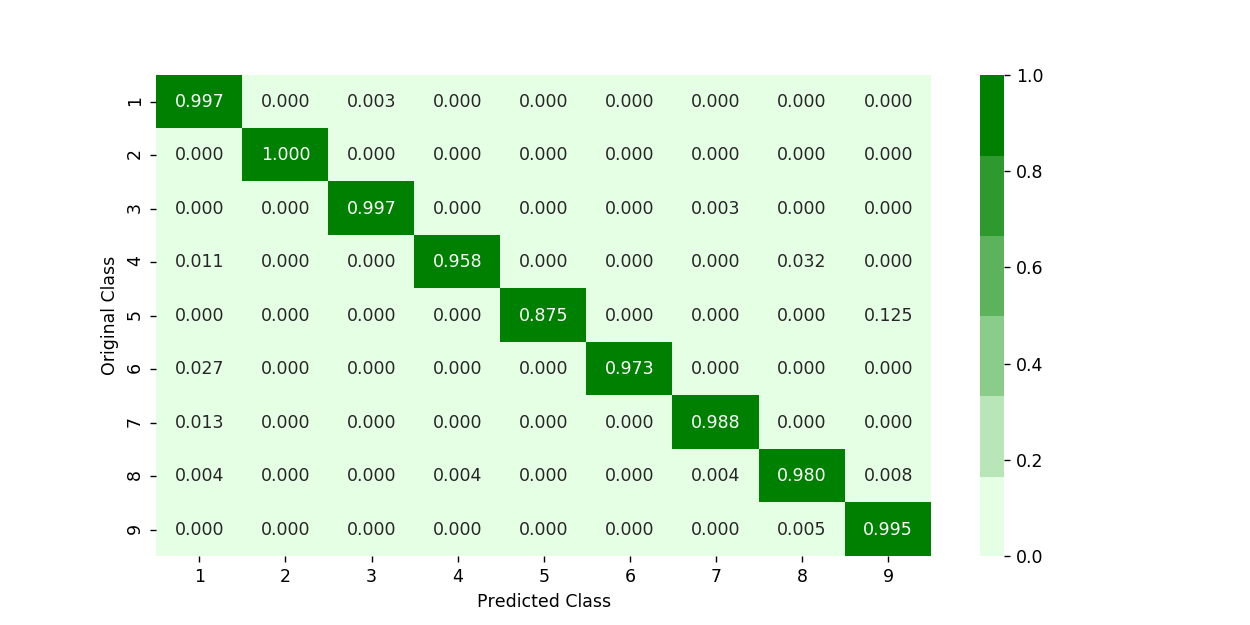

Sum of rows in precision matrix [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [ ]:

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
    
predict_y = sig_clf.predict_proba(X_train_asm)

print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_asm, predict_y))
predict_y = sig_clf.predict_proba(X_cv_asm)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_asm, predict_y))
predict_y = sig_clf.predict_proba(X_test_asm)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_asm, predict_y))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

<h3>  Multivariate Analysis on final fearures</h3>

<IPython.core.display.Javascript object>


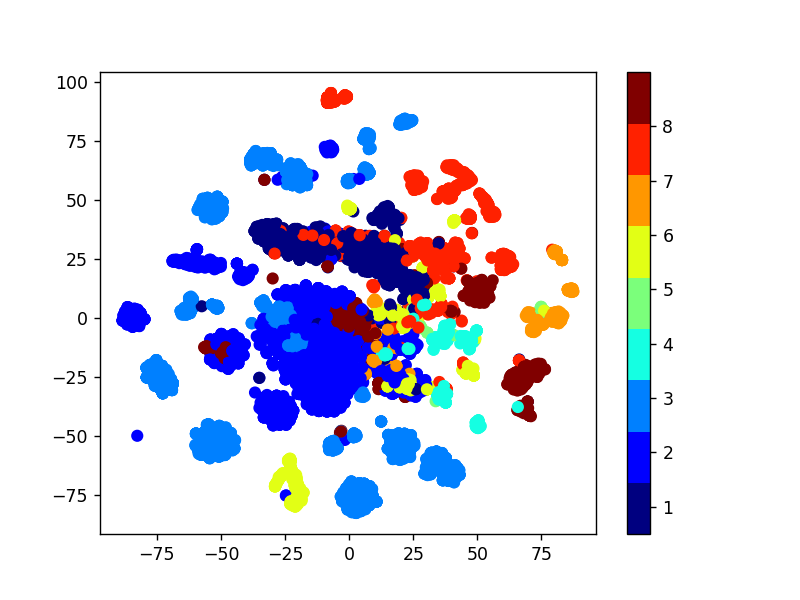

In [ ]:
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(result_x, axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=result_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(9))
plt.clim(0.5, 9)
plt.show()

<h3> Train and Test split</h3>

In [ ]:
X_train, X_test_merge, y_train, y_test_merge = train_test_split(result_x, result_y,stratify=result_y,test_size=0.20)
X_train_merge, X_cv_merge, y_train_merge, y_cv_merge = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

<h3> Random Forest Classifier on final features</h3>

log_loss for c =  10 is 0.0461221662017
log_loss for c =  50 is 0.0375229563452
log_loss for c =  100 is 0.0359765822455
log_loss for c =  500 is 0.0358291883873
log_loss for c =  1000 is 0.0358403093496
log_loss for c =  2000 is 0.0357908022178
log_loss for c =  3000 is 0.0355909487962


<IPython.core.display.Javascript object>


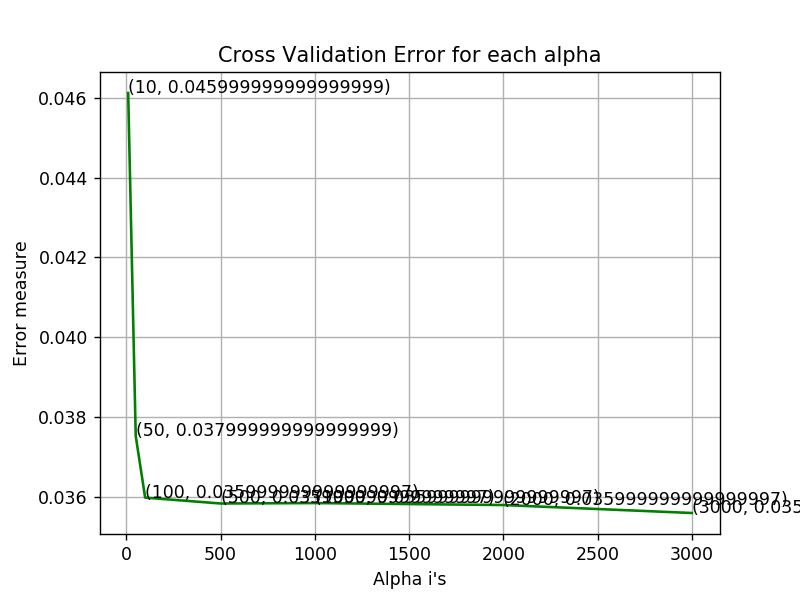

For values of best alpha =  3000 The train log loss is: 0.0166267614753
For values of best alpha =  3000 The cross validation log loss is: 0.0355909487962
For values of best alpha =  3000 The test log loss is: 0.0401141303589


In [ ]:

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train_merge,y_train_merge)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train_merge, y_train_merge)
    predict_y = sig_clf.predict_proba(X_cv_merge)
    cv_log_error_array.append(log_loss(y_cv_merge, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train_merge,y_train_merge)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train_merge, y_train_merge)

predict_y = sig_clf.predict_proba(X_train_merge)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_merge, predict_y))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_merge, predict_y))

<h3> XgBoost Classifier on final features</h3>

log_loss for c =  10 is 0.0898979446265
log_loss for c =  50 is 0.0536946658041
log_loss for c =  100 is 0.0387968186177
log_loss for c =  500 is 0.0347960327293
log_loss for c =  1000 is 0.0334668083237
log_loss for c =  2000 is 0.0316569078846
log_loss for c =  3000 is 0.0315972694477


<IPython.core.display.Javascript object>


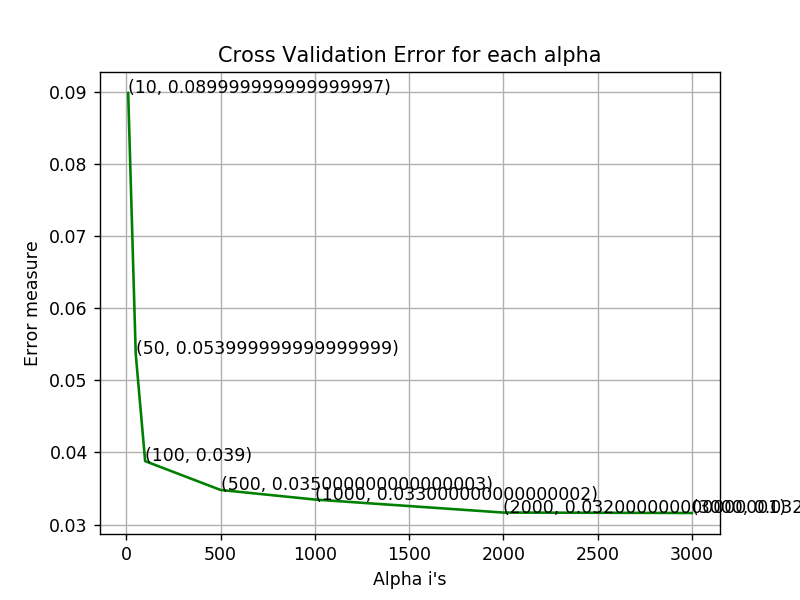

For values of best alpha =  3000 The train log loss is: 0.0111918809342
For values of best alpha =  3000 The cross validation log loss is: 0.0315972694477
For values of best alpha =  3000 The test log loss is: 0.0323978515915


In [ ]:

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i)
    x_cfl.fit(X_train_merge,y_train_merge)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_merge, y_train_merge)
    predict_y = sig_clf.predict_proba(X_cv_merge)
    cv_log_error_array.append(log_loss(y_cv_merge, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=3000,nthread=-1)
x_cfl.fit(X_train_merge,y_train_merge,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_merge, y_train_merge)

predict_y = sig_clf.predict_proba(X_train_merge)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_merge, predict_y))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_merge, predict_y))

In [ ]:
print (random_cfl.best_params_)

{'subsample': 1, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.15, 'colsample_bytree': 0.3}
